# Daily mean pre-processor notebook

##### Authors : Nic Tarasewicz nic.tarasewicz@colorado.edu [@ntarasewicz](https://github.com/ntarasewicz), adapted directly from Will Wieder wwieder@ucar.edu [@wwieder](https://github.com/wwieder) who modified from work by Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513)

##### Last revised: 2023-06-01
_______

This is a notebook for reading AmeriFlux evaluation files, saving as .csv, and visualizing.

In [5]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import xarray as xr

from glob import glob
from os.path import join

import tqdm
import cftime

In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2022.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [44]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32967 instead
  warnings.warn(


<Client: 'tcp://10.12.206.49:36032' processes=0 threads=0, memory=0 B>

---------------------------

# Import model output

### _only read these variables from the whole netcdf files_


In [24]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW','Vcmx25Z',
                 'ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','FPSN','H2OSOI','SNOW_DEPTH','TBOT','TSOI',
                 'BTRANMN','TV']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

In [7]:
# -- fix timestamp on CTSM files so they can be matched with eval files

def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [8]:
#-- path to save the csv files:
csv_dir = "/glade/scratch/nict/"

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.mkdir(csv_dir)

### CLM v1

In [25]:
# load CLM5.1-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test1_sp'

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "sim_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[sim_var_name]=field
    #-- shift simulation data by one time step
    df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values

---------------------------
Extracting data for US-NR1_test1_sp
All simulation files for all years: [ 6 files]
Reading all simulation files took: 2.7083427906036377 s.


100%|██████████| 22/22 [00:00<00:00, 1540.22it/s]


### CLM 2.66

In [10]:
# load CLM5.1-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test1_sp_LAI'
#/glade/scratch/jayka/archive/US-NR1_test1_sp_LAI/lnd/hist

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "sim2.6_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[sim_var_name]=field
    #-- shift simulation data by one time step
    df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values
    
df_ctsm26 = df_ctsm

---------------------------
Extracting data for US-NR1_test1_sp_LAI
All simulation files for all years: [ 6 files]
Reading all simulation files took: 2.876458168029785 s.


100%|██████████| 22/22 [00:00<00:00, 1502.40it/s]


### CLM 2.5

In [11]:
# load CLM5.1-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test1_sp_LAI2'
# /glade/scratch/jayka/archive/US-NR1_test1_sp_LAI2/lnd/hist

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "sim2.5_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[sim_var_name]=field
    #-- shift simulation data by one time step
    df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values
    
df_ctsm25 = df_ctsm

---------------------------
Extracting data for US-NR1_test1_sp_LAI2
All simulation files for all years: [ 6 files]
Reading all simulation files took: 2.7879512310028076 s.


100%|██████████| 22/22 [00:00<00:00, 1575.49it/s]


### FATES v1

In [23]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW',
                 'ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','FATES_GPP','H2OSOI','SNOW_DEPTH','TBOT','TSOI']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

# load FATES-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test_fatesSP'

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_fates = pd.DataFrame({'time':ds_ctsm.time})
df_fates['time'] = pd.to_datetime(df_fates['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "fates_sim_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_fates[sim_var_name]=field
    #-- shift simulation data by one time step
    df_fates[sim_var_name]=df_fates[sim_var_name].shift(-1).values

---------------------------
Extracting data for US-NR1_test_fatesSP
All simulation files for all years: [ 6 files]
Reading all simulation files took: 2.975466251373291 s.


100%|██████████| 19/19 [00:00<00:00, 1487.04it/s]


### FATES LAI 2.5

In [13]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW',
                 'ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','FATES_GPP','H2OSOI','SNOW_DEPTH','TBOT','TSOI']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

# load FATES-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test_fatesSP_LAI2'
# /glade/scratch/jayka/archive/US-NR1_test_fatesSP_LAI2/lnd/hist

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_fates = pd.DataFrame({'time':ds_ctsm.time})
df_fates['time'] = pd.to_datetime(df_fates['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "fates_sim2.5_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_fates[sim_var_name]=field
    #-- shift simulation data by one time step
    df_fates[sim_var_name]=df_fates[sim_var_name].shift(-1).values
    
df_fates25 = df_fates

---------------------------
Extracting data for US-NR1_test_fatesSP_LAI2
All simulation files for all years: [ 6 files]
Reading all simulation files took: 2.759178400039673 s.


100%|██████████| 19/19 [00:00<00:00, 1524.73it/s]


### FATES LAI 2.66

In [14]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW',
                 'ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','FATES_GPP','H2OSOI','SNOW_DEPTH','TBOT','TSOI']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

# load FATES-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test_fatesSP_LAI'
#/glade/scratch/jayka/archive/US-NR1_test_fatesSP_LAI/lnd/hist

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_fates = pd.DataFrame({'time':ds_ctsm.time})
df_fates['time'] = pd.to_datetime(df_fates['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "fates_sim2.6_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_fates[sim_var_name]=field
    #-- shift simulation data by one time step
    df_fates[sim_var_name]=df_fates[sim_var_name].shift(-1).values
    
df_fates26 = df_fates

---------------------------
Extracting data for US-NR1_test_fatesSP_LAI
All simulation files for all years: [ 6 files]
Reading all simulation files took: 3.884229898452759 s.


100%|██████████| 19/19 [00:00<00:00, 1574.41it/s]


# Import obs data

In [ ]:
'''
# load US-NR1 tower data
# original name: AMF_US-NR1_FLUXNET_FULLSET_HH_1998-2016_3-5
nr1 = pd.read_csv('/glade/scratch/nict/us-nr1_fullset_1998-2016.csv')
nr1 = pd.DataFrame(nr1)
nr1['TIMESTAMP_START'] = pd.to_datetime(nr1['TIMESTAMP_START'], format='%Y%m%d%H%M')
nr1['TIMESTAMP_END'] = pd.to_datetime(nr1['TIMESTAMP_END'], format='%Y%m%d%H%M')

# extract relevant variables and convert US-NR1 data to single dataframe 
df_af = pd.DataFrame({'time':nr1.TIMESTAMP_START,
                  'nee':nr1.NEE_VUT_REF,
                 'gpp':nr1.GPP_NT_VUT_REF,
                 # 'LE':nr1.LE_F_MDS_QC,
                'LE':nr1.LE_F_MDS,
                 'h':nr1.H_F_MDS,
                'nr':nr1.NETRAD})
df_af = df_af.set_index('time')
df_af = df_af.loc['2010-01-01':'2015-12-31']

# filter net radiation above 0
df_af_filter = df_af[(df_af.nr >= -200)]

# convert units

# convert NEE units from  umolm-2s-1 to gc/m2/s
#df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
#df_all ['GPP']= df_all ['GPP']*(12.01/1000000)
# -- convert gc/m2/s to gc/m2/day
# df_all ['NEE']= df_all['NEE']*60*60*24
# df_all ['GPP']= df_all['GPP']*60*60*24


df_af['nee'] = df_af['nee']*(12.01/1000000)
df_af['gpp'] = df_af['gpp']*(12.01/1000000)

df_af['nee'] = df_af['nee']*60*60*24
df_af['gpp'] = df_af['gpp']*60*60*24

df_af.head(5)
'''

In [26]:
# import tower obs with multiple gpp, le, and h calculation methods
# load US-NR1 tower data
# original name: AMF_US-NR1_FLUXNET_FULLSET_HH_1998-2016_3-5
nr1 = pd.read_csv('/glade/scratch/nict/us-nr1_fullset_1998-2016.csv')
nr1 = pd.DataFrame(nr1)
nr1['time'] = pd.to_datetime(nr1['TIMESTAMP_START'], format='%Y%m%d%H%M')

# extract relevant variables and convert US-NR1 data to single dataframe 
df_af = pd.DataFrame(nr1)
df_af = df_af.set_index('time')
df_af = df_af.loc['2010-01-01':'2015-12-31']


# filter net radiation above 0
# df_af_filter = df_af[(df_af.nr >= -200)]


# calculate mean and std of GPP, LE, and H calculation methods
col = df_af.loc[: , "GPP_NT_VUT_REF":"GPP_NT_CUT_95"]
df_af['gpp_mean'] = col.mean(axis=1)
df_af['gpp_std'] = col.std(axis=1)

# col = df_af.loc[: , "LE_F_MDS":"LE_CORR_JOINTUNC"]
# df_af['le_std'] = col.std(axis=1)
df_af['le_mean'] = df_af["LE_F_MDS"]


col = df_af.loc[: , "H_F_MDS":"H_CORR_JOINTUNC"]
df_af['h_mean'] = col.mean(axis=1)
df_af['h_std'] = col.std(axis=1)


# convert units
df_af['gpp_mean'] = df_af['gpp_mean']*(12.01/1000000)
df_af['gpp_mean'] = df_af['gpp_mean']*60*60*24

df_af['gpp_std'] = df_af['gpp_std']*(12.01/1000000)
df_af['gpp_std'] = df_af['gpp_std']*60*60*24



df_af = pd.DataFrame({'time':df_af.TIMESTAMP_START,
                      'gpp':df_af.GPP_NT_VUT_REF,
                    'gpp_mean':df_af.gpp_mean,
                      'gpp_std':df_af.gpp_std,
                    'le_mean':df_af.le_mean,
                      # 'le_std':df_af.le_std,
                    'h_mean':df_af.h_mean,
                      'h_std':df_af.h_std,
                'LE':df_af.LE_F_MDS,
                 'h':df_af.H_F_MDS,
                'nr':df_af.NETRAD})

df_af['gpp'] = df_af['gpp']*(12.01/1000000)
df_af['gpp'] = df_af['gpp']*60*60*24


df_af.head()

time       gpp  gpp_mean   gpp_std  le_mean  \
time                                                                       
2010-01-01 00:00:00  201001010000 -0.204521 -0.187292  0.061841 -35.6600   
2010-01-01 00:30:00  201001010030  0.486259  0.440754  0.142458  11.9008   
2010-01-01 01:00:00  201001010100 -0.656675 -0.598409  0.194402  11.9685   
2010-01-01 01:30:00  201001010130 -0.636972 -0.580392  0.188604  40.9100   
2010-01-01 02:00:00  201001010200  0.212252  0.191560  0.062191  12.2199   

                       h_mean      h_std       LE        h     nr  
time                                                               
2010-01-01 00:00:00  2.945611  59.044449 -35.6600 -35.2051 -45.39  
2010-01-01 00:30:00  2.555011  58.415367  11.9008 -35.5515 -38.65  
2010-01-01 01:00:00  2.947244  58.464629  11.9685 -35.0673 -50.65  
2010-01-01 01:30:00  2.859700  58.975804  40.9100 -35.5046 -30.82  
2010-01-01 02:00:00  2.838033  58.779713  12.2199 -35.2757 -18.63

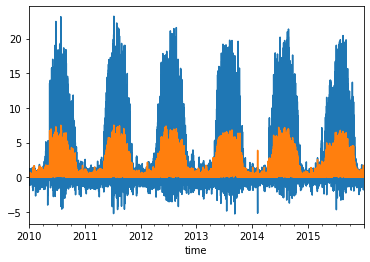

In [101]:
df_af.gpp_mean.plot();
df_af.gpp_std.plot();

In [27]:
# merge and rename simulation data
df_all=pd.concat([df_ctsm, df_fates], axis=1, join='inner')
df_all = df_all.loc[:,~df_all.columns.duplicated()]
df_all = df_all.set_index('time')
df_all.index = pd.to_datetime(df_all.index)

# -- Latent Heat Flux:
# -- EFLX_LH_TOT = FCEV + FCTR +FGEV (ground, canpoy, and transpiration)
clm_var = 'sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

clm_var = 'fates_sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim_FCEV']+ df_all['fates_sim_FCTR']+ df_all['fates_sim_FGEV']


# -- Net Radiation:
# -- Rnet = FSA-FIRA
clm_var = 'sim_Rnet'
df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

clm_var = 'fates_sim_Rnet'
df_all [clm_var] = df_all ['fates_sim_FSA']-df_all['fates_sim_FIRA']

# -- Net Ecosystem Exchange
# -- NEE = GPP- (AR+HR)
# -- It seems like the sign are opposite so we calculated negative NEE
# clm_var = 'sim_NEE'
# df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

# -- Convert simulation units:
# df_all['sim_NEE']= df_all['sim_NEE']*60*60*24
# df_all['sim_GPP']= df_all['sim_GPP']*60*60*24
# df_all['sim_AR']= df_all['sim_AR']*60*60*24
# df_all['sim_HR']= df_all['sim_HR']*60*60*24
# df_all['sim_ER']= df_all['sim_HR']+df_all['sim_AR']

# Convert atmospheric temperature from K to Deg C
df_all['sim_TBOT'] = df_all['sim_TBOT'] - 273.15
df_all['fates_sim_TBOT'] = df_all['fates_sim_TBOT'] - 273.15

# Convert photosynthesis from umol m-2 s-1 to to gc/m2/s
df_all['sim_FPSN'] = df_all['sim_FPSN']*(12.01/1000000)
# -- convert gc/m2/s to gc/m2/day
df_all['sim_FPSN'] = df_all['sim_FPSN']*60*60*24

# Convert FATES_GPP from kgc m-2 s-1 to gc/m2/day 
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*1000
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*60*60*24

#-- extract year, month, day, hour information from time
df_all['year'] = df_all.index.year
df_all['month'] = df_all.index.month
df_all['day'] = df_all.index.day
df_all['hour'] = df_all.index.hour

# tzone_shift = ds_eval.TimeDiffUtcLt
# hard coded for Mountain time
tzone_shift = -7

# convert to local time
df_all['local_time']= df_all.index + datetime.timedelta(hours=int(tzone_shift))
df_all['local_hour'] = df_all['local_time'].dt.hour
df_all = df_all.set_index('local_time')
df_all = df_all.loc['2010-01-01':'2015-12-31'] # filter time

# merge with AmeriFlux data
# Outer join based on index
df = pd.merge(df_all, df_af, left_index = True, right_index = True,how = "outer") 

# Write out 30 minute data
csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
df.to_csv(csv_out,index=False)


# -- Calculate daily means
df['local_time']= df.index + datetime.timedelta(hours=int(tzone_shift))
df['local_hour'] = df['local_time'].dt.hour

df['local_date'] = df['local_time'].astype('M8[D]')
df_day = df.groupby(df['local_date']).mean()
#mask out days with missing values
df_count = df.groupby(df['local_date']).count()
df_day = df_day.where(df_count==48)

# Write out daily minute data
csv_out = join(csv_dir, "mean_daily_"+neon_site+".csv")
df_day.to_csv(csv_out,index=True)

# Merge and export large hourly .csv

In [28]:
# merge and rename simulation data
df_all=pd.concat([df_ctsm, df_ctsm26, df_ctsm25,
                  df_fates, df_fates25, df_fates26], axis=1, join='inner')
df_all = df_all.loc[:,~df_all.columns.duplicated()]
df_all = df_all.set_index('time')
df_all.index = pd.to_datetime(df_all.index)

# -- Latent Heat Flux:
# -- EFLX_LH_TOT = FCEV + FCTR +FGEV (ground, canpoy, and transpiration)
clm_var = 'sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

clm_var = 'sim2.5_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim2.5_FCEV']+ df_all['sim2.5_FCTR']+ df_all['sim2.5_FGEV']

clm_var = 'sim2.6_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim2.6_FCEV']+ df_all['sim2.6_FCTR']+ df_all['sim2.6_FGEV']


clm_var = 'fates_sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim_FCEV']+ df_all['fates_sim_FCTR']+ df_all['fates_sim_FGEV']

clm_var = 'fates_sim2.5_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim2.5_FCEV']+ df_all['fates_sim2.5_FCTR']+ df_all['fates_sim2.5_FGEV']

clm_var = 'fates_sim2.6_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim2.6_FCEV']+ df_all['fates_sim2.6_FCTR']+ df_all['fates_sim2.6_FGEV']


# -- Net Radiation:
# -- Rnet = FSA-FIRA
clm_var = 'sim_Rnet'
df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

clm_var = 'sim2.5_Rnet'
df_all [clm_var] = df_all ['sim2.5_FSA']-df_all['sim2.5_FIRA']

clm_var = 'sim2.6_Rnet'
df_all [clm_var] = df_all ['sim2.6_FSA']-df_all['sim2.6_FIRA']


clm_var = 'fates_sim_Rnet'
df_all [clm_var] = df_all ['fates_sim_FSA']-df_all['fates_sim_FIRA']

clm_var = 'fates_sim2.5_Rnet'
df_all [clm_var] = df_all ['fates_sim2.5_FSA']-df_all['fates_sim2.5_FIRA']

clm_var = 'fates_sim2.6_Rnet'
df_all [clm_var] = df_all ['fates_sim2.6_FSA']-df_all['fates_sim2.6_FIRA']


# Convert atmospheric temperature from K to Deg C
df_all['sim_TBOT'] = df_all['sim_TBOT'] - 273.15
df_all['sim2.5_TBOT'] = df_all['sim2.5_TBOT'] - 273.15
df_all['sim2.6_TBOT'] = df_all['sim2.6_TBOT'] - 273.15
df_all['fates_sim_TBOT'] = df_all['fates_sim_TBOT'] - 273.15
df_all['fates_sim2.5_TBOT'] = df_all['fates_sim2.5_TBOT'] - 273.15
df_all['fates_sim2.6_TBOT'] = df_all['fates_sim2.6_TBOT'] - 273.15


# Convert photosynthesis from umol m-2 s-1 to to gc/m2/s
df_all['sim_FPSN'] = df_all['sim_FPSN']*(12.01/1000000)
df_all['sim2.5_FPSN'] = df_all['sim2.5_FPSN']*(12.01/1000000)
df_all['sim2.6_FPSN'] = df_all['sim2.6_FPSN']*(12.01/1000000)
# -- convert gc/m2/s to gc/m2/day
df_all['sim_FPSN'] = df_all['sim_FPSN']*60*60*24
df_all['sim2.5_FPSN'] = df_all['sim2.5_FPSN']*60*60*24
df_all['sim2.6_FPSN'] = df_all['sim2.6_FPSN']*60*60*24

# Convert FATES_GPP from kgc m-2 s-1 to gc/m2/day 
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*1000
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*60*60*24

df_all['fates_sim2.5_FATES_GPP'] = df_all['fates_sim2.5_FATES_GPP']*1000
df_all['fates_sim2.5_FATES_GPP'] = df_all['fates_sim2.5_FATES_GPP']*60*60*24

df_all['fates_sim2.6_FATES_GPP'] = df_all['fates_sim2.6_FATES_GPP']*1000
df_all['fates_sim2.6_FATES_GPP'] = df_all['fates_sim2.6_FATES_GPP']*60*60*24


#-- extract year, month, day, hour information from time
df_all['year'] = df_all.index.year
df_all['month'] = df_all.index.month
df_all['day'] = df_all.index.day
df_all['hour'] = df_all.index.hour

# tzone_shift = ds_eval.TimeDiffUtcLt
# hard coded for Mountain time
tzone_shift = -7

# convert to local time
df_all['local_time']= df_all.index + datetime.timedelta(hours=int(tzone_shift))
df_all['local_hour'] = df_all['local_time'].dt.hour
df_all = df_all.set_index('local_time')
df_all = df_all.loc['2010-01-01':'2015-12-31'] # filter time

# merge with AmeriFlux data
# Outer join based on index
df = pd.merge(df_all, df_af, left_index = True, right_index = True,how = "outer") 

# Write out 30 minute data
csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
df.to_csv(csv_out,index=False)


# -- Calculate hourly means
df['local_time']= df.index + datetime.timedelta(hours=int(tzone_shift))
df['local_hour'] = df['local_time'].dt.hour

df['local_date'] = df['local_time'].astype('M8[h]')
df_day = df.groupby(df['local_date']).mean()

#mask out days with missing values
# df_count = df.groupby(df['local_date']).count()
# df_day = df_day.where(df_count==48)

# Write out daily minute data
csv_out = join(csv_dir, "mean_hourly_multi_run.csv")
df_day.to_csv(csv_out,index=True)

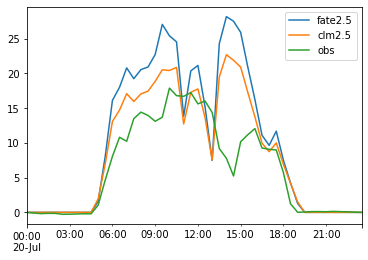

In [34]:
df.loc['2015-07-20', 'fates_sim2.5_FATES_GPP'].plot(label='fate2.5');
df.loc['2015-07-20', 'sim2.5_FPSN'].plot(label='clm2.5');
df.loc['2015-07-20', 'gpp_mean'].plot(label='obs');
plt.legend()

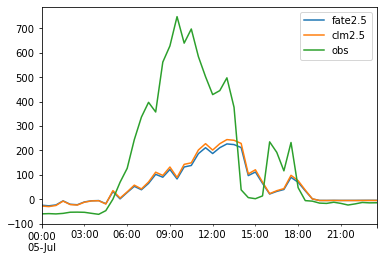

In [33]:
df.loc['2015-07-05', 'fates_sim2.5_Rnet'].plot(label='fate2.5');
df.loc['2015-07-05', 'sim2.5_Rnet'].plot(label='clm2.5');
df.loc['2015-07-05', 'nr'].plot(label='obs');
plt.legend()

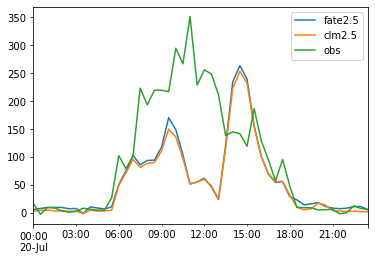

In [32]:
df.loc['2015-07-20', 'fates_sim2.5_EFLX_LH_TOT'].plot(label='fate2.5');
df.loc['2015-07-20', 'sim2.5_EFLX_LH_TOT'].plot(label='clm2.5');
df.loc['2015-07-20', 'le_mean'].plot(label='obs');
plt.legend()

# Plotting Hourly

In [58]:
df1 = pd.read_csv('/glade/scratch/nict/mean_hourly_multi_run.csv')

df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df1 = df1.set_index('time')

# extract relevant variables and drop NANs
# df1 = df1[['sim_GPP','sim_NEE','sim_Rnet','sim_EFLX_LH_TOT','nr','gpp','LE','nee','DOY','time2']].copy()

# remove outliers for net radiation 
# upper_outlier_nr, lower_outlier_nr = df1.nr.quantile(.98), df1.nr.quantile(.02)
# df1 = df1[(df1.nr < upper_outlier_nr) & (df1.nr > lower_outlier_nr)]

# remove extreme values for net radiation 
df1 = df1[(df1.nr >= -200)]

# df1 = df1.dropna()

# Group by DOY and calculate mean and std
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()

In [59]:
climo1

sim_QVEGT     sim_QVEGE     sim_QSOIL  sim_RAIN  sim_SNOW  \
time2                                                                 
1      4.967630e-07  7.716220e-07  6.722215e-07       0.0  0.000000   
2      7.172604e-07  4.379546e-07  8.716483e-07       0.0  0.000038   
3      5.375770e-07  9.088802e-07  7.392580e-07       0.0  0.000023   
4      6.294718e-07  8.666002e-07  7.989858e-07       0.0  0.000019   
5      7.827503e-07  1.023146e-06  8.069089e-07       0.0  0.000009   
...             ...           ...           ...       ...       ...   
362    4.165025e-07  8.070600e-07  7.032493e-07       0.0  0.000014   
363    3.312866e-07  8.339327e-07  5.854688e-07       0.0  0.000009   
364    5.565332e-07  4.933616e-07  6.450800e-07       0.0  0.000029   
365    1.372963e-07  1.042047e-06  4.170807e-07       0.0  0.000020   
366    1.782656e-07 -8.795315e-09  3.464048e-07       0.0  0.000000   

       sim_Vcmx25Z  sim_ELAI  sim_FCEV  sim_FCTR  sim_FGEV  ...       gpp  \
time2                                                       ...             
1        45.471459  0.810750  1.929827  1.242404  1.880059  ... -0.056229   
2        45.544519  0.810592  1.095324  1.793868  2.405022  ...  0.087530   
3        45.587998  0.810434  2.273109  1.344480  2.049581  ...  0.073040   
4        45.693990  0.810275  2.167367  1.574309  2.205399  ...  0.031601   
5        45.829264  0.810117  2.558888  1.957659  2.220644  ...  0.008604   
...            ...       ...       ...       ...       ...  ...       ...   
362      44.953979  0.811384  2.018457  1.041673  1.960892  ... -0.020649   
363      44.913007  0.811225  2.085666  0.828548  1.659628  ... -0.149582   
364      45.239263  0.811082  1.233897  1.391890  1.813095  ... -0.102428   
365      45.439134  0.810925  2.606161  0.343378  1.182299  ... -0.067599   
366      44.644952  0.810829 -0.021997  0.445842  0.981954  ... -0.243733   

       gpp_mean   gpp_std    le_mean     h_mean       h_std         LE  \
time2                                                                    
1     -0.051836  0.124416  29.759011  19.757012   54.552558  29.759011   
2      0.062069  0.128944  30.312108  16.603071   58.083048  30.312108   
3      0.062438  0.119651  23.079900  16.573589   56.175719  23.079900   
4      0.023474  0.127142  23.030261  16.085479   56.002186  23.030261   
5      0.013471  0.114784  28.331126 -25.262767  112.531272  28.331126   
...         ...       ...        ...        ...         ...        ...   
362   -0.024067  0.105100  27.751118  35.490926   58.614144  27.751118   
363   -0.128053  0.128760  32.692101  23.141739   50.197520  32.692101   
364   -0.098153  0.120400  26.018965  25.658918   51.458629  26.018965   
365   -0.056432  0.115545  36.119830  23.399392   48.819846  36.119830   
366   -0.220438  0.094120   2.856344  15.364396   42.128314   2.856344   

               h         nr    DOY  
time2                               
1       7.961280  18.583212    1.0  
2       6.706277  27.776944    2.0  
3       5.671027  14.969969    3.0  
4       4.391036  19.687604    4.0  
5      13.556132  25.426181    5.0  
...          ...        ...    ...  
362    35.923138  20.622882  362.0  
363    15.185805  20.140208  363.0  
364    23.218458  16.847774  364.0  
365    18.487217  21.094062  365.0  
366     5.759167  29.888813  366.0  

[366 rows x 150 columns]

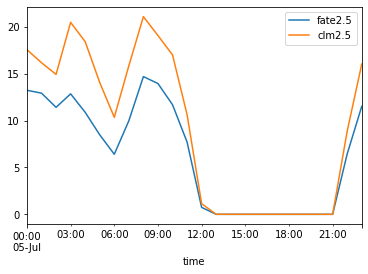

In [63]:
df1.loc['2014-07-05', 'fates_sim_FATES_GPP'].plot(label='fate2.5');
df1.loc['2014-07-05', 'sim2.5_FPSN'].plot(label='clm2.5');
plt.legend()

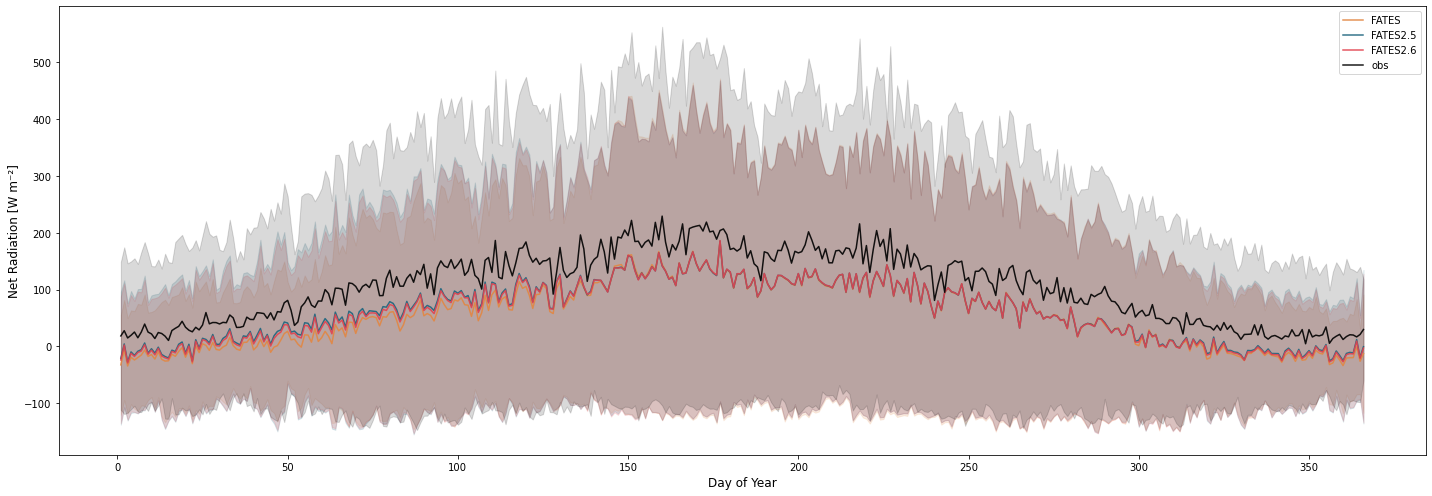

In [48]:
# colorf = '#2EC1D1'
# colorf5 = '#2E70D1'
# colorf6 = '#2ED18F'

# colorc = '#DD3D22'
# colorc5 = '#DD9B22'
# colorc6 = '#DD2264'
colorc='#e28743'
colorc5='#1d657e'
colorc6='#E2434F'
colorf='#e28743'
colorf5='#1d657e'
colorf6='#E2434F'

plt.figure(figsize=(20, 7),facecolor='w',edgecolor='k')

plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_Rnet'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_Rnet'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_Rnet'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_Rnet']-climo1SD['fates_sim_Rnet'], climo1['fates_sim_Rnet']+climo1SD['fates_sim_Rnet'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_Rnet']-climo1SD['fates_sim2.5_Rnet'], climo1['fates_sim2.5_Rnet']+climo1SD['fates_sim2.5_Rnet'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_Rnet']-climo1SD['fates_sim2.6_Rnet'], climo1['fates_sim2.6_Rnet']+climo1SD['fates_sim2.6_Rnet'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_Rnet'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_Rnet'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_Rnet'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_Rnet']-climo1SD['sim_Rnet'], climo1['sim_Rnet']+climo1SD['sim_Rnet'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_Rnet']-climo1SD['sim2.5_Rnet'], climo1['sim2.5_Rnet']+climo1SD['sim2.5_Rnet'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_Rnet']-climo1SD['sim2.6_Rnet'], climo1['sim2.6_Rnet']+climo1SD['sim2.6_Rnet'] ,alpha=0.15, color = colorc6)

plt.plot(climo1.DOY, climo1['nr'], color = 'black', label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['nr']-climo1SD['nr'], climo1['nr']+climo1SD['nr'],alpha=0.15, color = 'black')    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
# plt.savefig('/glade/scratch/nict/lai_fates_nr.png')
# plt.savefig('/glade/scratch/nict/lai__clm_nr.png')
plt.show()

# Merge and export large .csv

In [62]:
# merge and rename simulation data
df_all=pd.concat([df_ctsm, df_ctsm26, df_ctsm25,
                  df_fates, df_fates25, df_fates26], axis=1, join='inner')
df_all = df_all.loc[:,~df_all.columns.duplicated()]
df_all = df_all.set_index('time')
df_all.index = pd.to_datetime(df_all.index)

# -- Latent Heat Flux:
# -- EFLX_LH_TOT = FCEV + FCTR +FGEV (ground, canpoy, and transpiration)
clm_var = 'sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

clm_var = 'sim2.5_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim2.5_FCEV']+ df_all['sim2.5_FCTR']+ df_all['sim2.5_FGEV']

clm_var = 'sim2.6_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim2.6_FCEV']+ df_all['sim2.6_FCTR']+ df_all['sim2.6_FGEV']


clm_var = 'fates_sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim_FCEV']+ df_all['fates_sim_FCTR']+ df_all['fates_sim_FGEV']

clm_var = 'fates_sim2.5_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim2.5_FCEV']+ df_all['fates_sim2.5_FCTR']+ df_all['fates_sim2.5_FGEV']

clm_var = 'fates_sim2.6_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim2.6_FCEV']+ df_all['fates_sim2.6_FCTR']+ df_all['fates_sim2.6_FGEV']


# -- Net Radiation:
# -- Rnet = FSA-FIRA
clm_var = 'sim_Rnet'
df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

clm_var = 'sim2.5_Rnet'
df_all [clm_var] = df_all ['sim2.5_FSA']-df_all['sim2.5_FIRA']

clm_var = 'sim2.6_Rnet'
df_all [clm_var] = df_all ['sim2.6_FSA']-df_all['sim2.6_FIRA']


clm_var = 'fates_sim_Rnet'
df_all [clm_var] = df_all ['fates_sim_FSA']-df_all['fates_sim_FIRA']

clm_var = 'fates_sim2.5_Rnet'
df_all [clm_var] = df_all ['fates_sim2.5_FSA']-df_all['fates_sim2.5_FIRA']

clm_var = 'fates_sim2.6_Rnet'
df_all [clm_var] = df_all ['fates_sim2.6_FSA']-df_all['fates_sim2.6_FIRA']


# Convert atmospheric temperature from K to Deg C
df_all['sim_TBOT'] = df_all['sim_TBOT'] - 273.15
df_all['sim2.5_TBOT'] = df_all['sim2.5_TBOT'] - 273.15
df_all['sim2.6_TBOT'] = df_all['sim2.6_TBOT'] - 273.15
df_all['fates_sim_TBOT'] = df_all['fates_sim_TBOT'] - 273.15
df_all['fates_sim2.5_TBOT'] = df_all['fates_sim2.5_TBOT'] - 273.15
df_all['fates_sim2.6_TBOT'] = df_all['fates_sim2.6_TBOT'] - 273.15


# Convert photosynthesis from umol m-2 s-1 to to gc/m2/s
df_all['sim_FPSN'] = df_all['sim_FPSN']*(12.01/1000000)
df_all['sim2.5_FPSN'] = df_all['sim2.5_FPSN']*(12.01/1000000)
df_all['sim2.6_FPSN'] = df_all['sim2.6_FPSN']*(12.01/1000000)
# -- convert gc/m2/s to gc/m2/day
df_all['sim_FPSN'] = df_all['sim_FPSN']*60*60*24
df_all['sim2.5_FPSN'] = df_all['sim2.5_FPSN']*60*60*24
df_all['sim2.6_FPSN'] = df_all['sim2.6_FPSN']*60*60*24

# Convert FATES_GPP from kgc m-2 s-1 to gc/m2/day 
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*1000
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*60*60*24

df_all['fates_sim2.5_FATES_GPP'] = df_all['fates_sim2.5_FATES_GPP']*1000
df_all['fates_sim2.5_FATES_GPP'] = df_all['fates_sim2.5_FATES_GPP']*60*60*24

df_all['fates_sim2.6_FATES_GPP'] = df_all['fates_sim2.6_FATES_GPP']*1000
df_all['fates_sim2.6_FATES_GPP'] = df_all['fates_sim2.6_FATES_GPP']*60*60*24


#-- extract year, month, day, hour information from time
df_all['year'] = df_all.index.year
df_all['month'] = df_all.index.month
df_all['day'] = df_all.index.day
df_all['hour'] = df_all.index.hour

# tzone_shift = ds_eval.TimeDiffUtcLt
# hard coded for Mountain time
tzone_shift = -7

# convert to local time
df_all['local_time']= df_all.index + datetime.timedelta(hours=int(tzone_shift))
df_all['local_hour'] = df_all['local_time'].dt.hour
df_all = df_all.set_index('local_time')
df_all = df_all.loc['2010-01-01':'2015-12-31'] # filter time

# merge with AmeriFlux data
# Outer join based on index
df = pd.merge(df_all, df_af, left_index = True, right_index = True,how = "outer") 

# Write out 30 minute data
csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
df.to_csv(csv_out,index=False)


# -- Calculate daily means
df['local_time']= df.index + datetime.timedelta(hours=int(tzone_shift))
df['local_hour'] = df['local_time'].dt.hour

df['local_date'] = df['local_time'].astype('M8[D]')
df_day = df.groupby(df['local_date']).mean()
#mask out days with missing values
df_count = df.groupby(df['local_date']).count()
df_day = df_day.where(df_count==48)

# Write out daily minute data
csv_out = join(csv_dir, "mean_daily_multi_run.csv")
df_day.to_csv(csv_out,index=True)

# Plotting 

In [21]:
df1 = pd.read_csv('/glade/scratch/nict/mean_hourly_multi_run.csv')

df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df1 = df1.set_index('time')

# extract relevant variables and drop NANs
# df1 = df1[['sim_GPP','sim_NEE','sim_Rnet','sim_EFLX_LH_TOT','nr','gpp','LE','nee','DOY','time2']].copy()

# remove outliers for net radiation 
# upper_outlier_nr, lower_outlier_nr = df1.nr.quantile(.98), df1.nr.quantile(.02)
# df1 = df1[(df1.nr < upper_outlier_nr) & (df1.nr > lower_outlier_nr)]

# remove extreme values for net radiation 
df1 = df1[(df1.nr >= -200)]

# df1 = df1.dropna()

# Group by DOY and calculate mean and std
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()

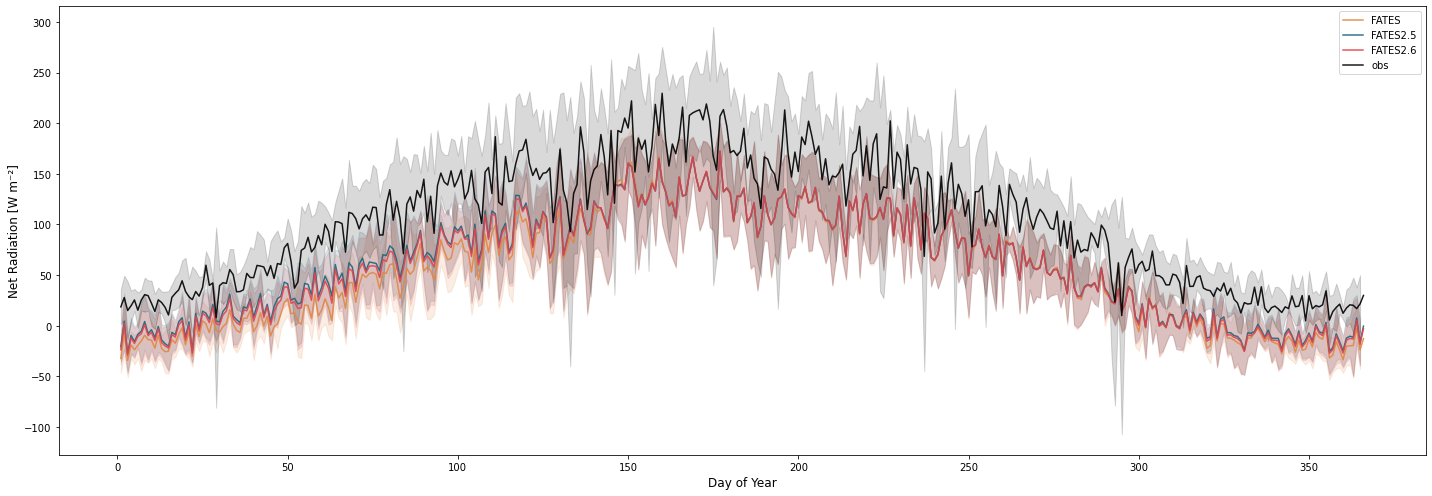

In [106]:
# colorf = '#2EC1D1'
# colorf5 = '#2E70D1'
# colorf6 = '#2ED18F'

# colorc = '#DD3D22'
# colorc5 = '#DD9B22'
# colorc6 = '#DD2264'
colorc='#e28743'
colorc5='#1d657e'
colorc6='#E2434F'
colorf='#e28743'
colorf5='#1d657e'
colorf6='#E2434F'

plt.figure(figsize=(20, 7),facecolor='w',edgecolor='k')

plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_Rnet'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_Rnet'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_Rnet'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_Rnet']-climo1SD['fates_sim_Rnet'], climo1['fates_sim_Rnet']+climo1SD['fates_sim_Rnet'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_Rnet']-climo1SD['fates_sim2.5_Rnet'], climo1['fates_sim2.5_Rnet']+climo1SD['fates_sim2.5_Rnet'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_Rnet']-climo1SD['fates_sim2.6_Rnet'], climo1['fates_sim2.6_Rnet']+climo1SD['fates_sim2.6_Rnet'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_Rnet'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_Rnet'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_Rnet'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_Rnet']-climo1SD['sim_Rnet'], climo1['sim_Rnet']+climo1SD['sim_Rnet'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_Rnet']-climo1SD['sim2.5_Rnet'], climo1['sim2.5_Rnet']+climo1SD['sim2.5_Rnet'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_Rnet']-climo1SD['sim2.6_Rnet'], climo1['sim2.6_Rnet']+climo1SD['sim2.6_Rnet'] ,alpha=0.15, color = colorc6)

plt.plot(climo1.DOY, climo1['nr'], color = 'black', label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['nr']-climo1SD['nr'], climo1['nr']+climo1SD['nr'],alpha=0.15, color = 'black')    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates_nr.png')
# plt.savefig('/glade/scratch/nict/lai__clm_nr.png')
plt.show()

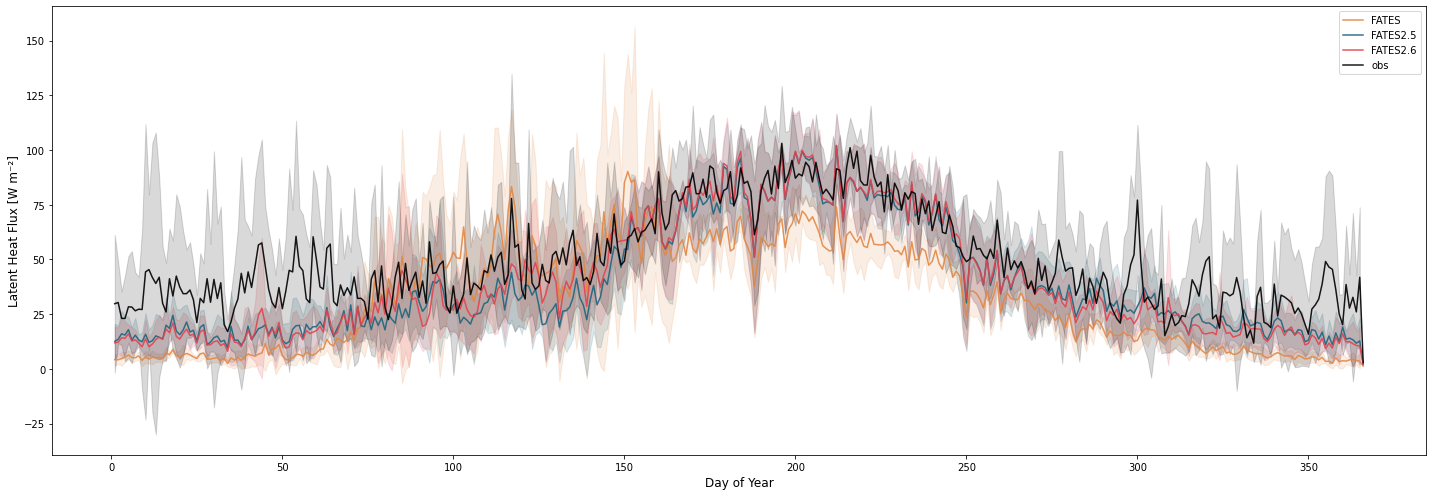

In [108]:
plt.figure(figsize=(20, 7),facecolor='w',edgecolor='k')

plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_EFLX_LH_TOT'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_EFLX_LH_TOT'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_EFLX_LH_TOT'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_EFLX_LH_TOT']-climo1SD['fates_sim_EFLX_LH_TOT'], climo1['fates_sim_EFLX_LH_TOT']+climo1SD['fates_sim_EFLX_LH_TOT'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_EFLX_LH_TOT']-climo1SD['fates_sim2.5_EFLX_LH_TOT'], climo1['fates_sim2.5_EFLX_LH_TOT']+climo1SD['fates_sim2.5_EFLX_LH_TOT'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_EFLX_LH_TOT']-climo1SD['fates_sim2.6_EFLX_LH_TOT'], climo1['fates_sim2.6_EFLX_LH_TOT']+climo1SD['fates_sim2.6_EFLX_LH_TOT'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_EFLX_LH_TOT'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_EFLX_LH_TOT'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_EFLX_LH_TOT'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_EFLX_LH_TOT']-climo1SD['sim_EFLX_LH_TOT'], climo1['sim_EFLX_LH_TOT']+climo1SD['sim_EFLX_LH_TOT'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_EFLX_LH_TOT']-climo1SD['sim2.5_EFLX_LH_TOT'], climo1['sim2.5_EFLX_LH_TOT']+climo1SD['sim2.5_EFLX_LH_TOT'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_EFLX_LH_TOT']-climo1SD['sim2.6_EFLX_LH_TOT'], climo1['sim2.6_EFLX_LH_TOT']+climo1SD['sim2.6_EFLX_LH_TOT'] ,alpha=0.15, color = colorc6)

plt.plot(climo1.DOY, climo1['le_mean'], color = 'black', label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['le_mean']-climo1SD['le_mean'], climo1['le_mean']+climo1SD['le_mean'],alpha=0.15, color = 'black')    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates_le.png')
# plt.savefig('/glade/scratch/nict/lai__clm_le.png')
plt.show()


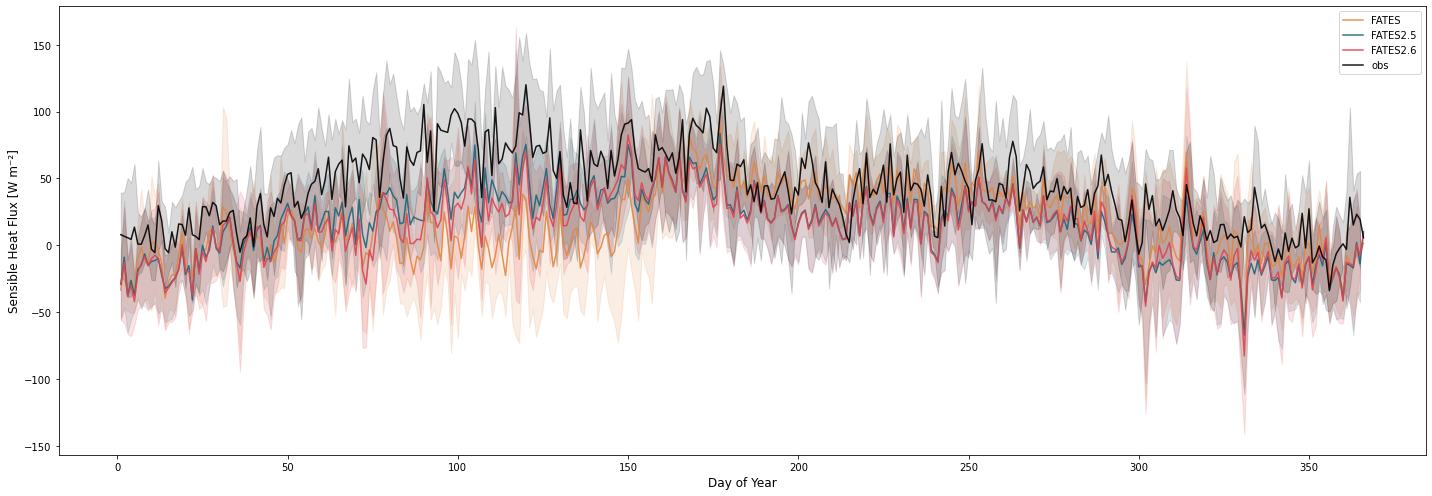

In [109]:
plt.figure(figsize=(20, 7),facecolor='w',edgecolor='k')

plot_var_desc = "Sensible Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FSH'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_FSH'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_FSH'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_FSH']-climo1SD['fates_sim_FSH'], climo1['fates_sim_FSH']+climo1SD['fates_sim_FSH'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FSH']-climo1SD['fates_sim2.5_FSH'], climo1['fates_sim2.5_FSH']+climo1SD['fates_sim2.5_FSH'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_FSH']-climo1SD['fates_sim2.6_FSH'], climo1['fates_sim2.6_FSH']+climo1SD['fates_sim2.6_FSH'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_FSH'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_FSH'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_FSH'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_FSH']-climo1SD['sim_FSH'], climo1['sim_FSH']+climo1SD['sim_FSH'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_FSH']-climo1SD['sim2.5_FSH'], climo1['sim2.5_FSH']+climo1SD['sim2.5_FSH'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_FSH']-climo1SD['sim2.6_FSH'], climo1['sim2.6_FSH']+climo1SD['sim2.6_FSH'] ,alpha=0.15, color = colorc6)

plt.plot(climo1.DOY, climo1['h'], color = 'black', label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['h']-climo1SD['h'], climo1['h']+climo1SD['h'],alpha=0.15, color = 'black')    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates_h.png')
# plt.savefig('/glade/scratch/nict/lai__clm_h.png')
plt.show()

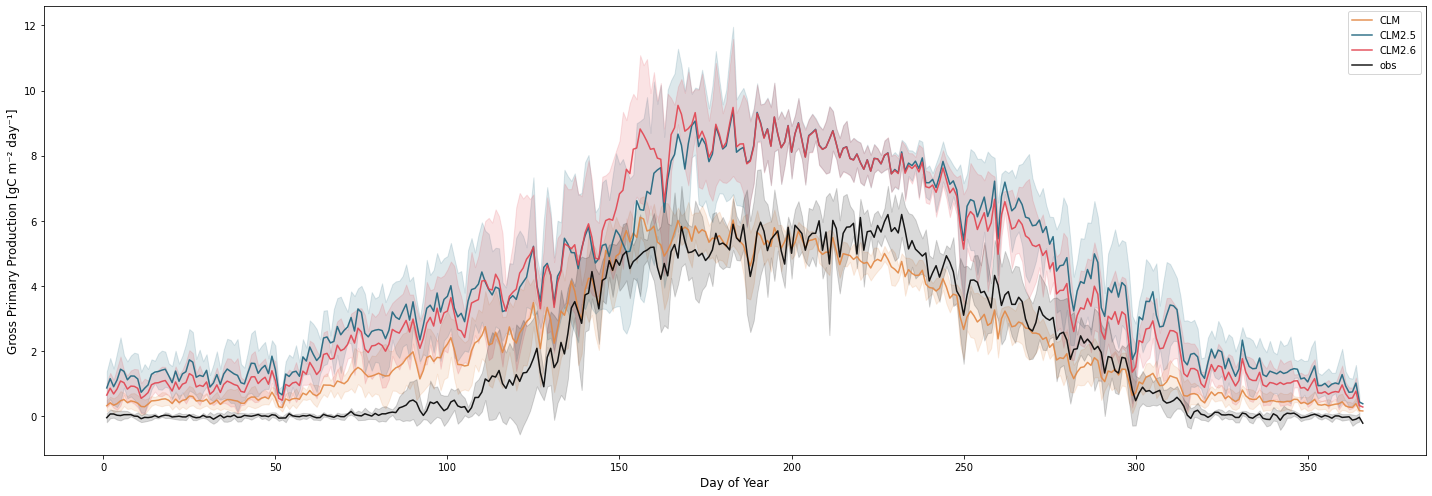

In [111]:
plt.figure(figsize=(20, 7),facecolor='w',edgecolor='k')

plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"

# plt.plot(climo1.DOY, climo1['fates_sim_FATES_GPP'], color = colorf, label="FATES", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['fates_sim2.5_FATES_GPP'], color = colorf5, label="FATES2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['fates_sim2.6_FATES_GPP'], color = colorf6, label="FATES2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['fates_sim_FATES_GPP']-climo1SD['fates_sim_FATES_GPP'], climo1['fates_sim_FATES_GPP']+climo1SD['fates_sim_FATES_GPP'],alpha=0.15, color = colorf)
# plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FATES_GPP']-climo1SD['fates_sim2.5_FATES_GPP'], climo1['fates_sim2.5_FATES_GPP']+climo1SD['fates_sim2.5_FATES_GPP'],alpha=0.15, color = colorf5)
# plt.fill_between(climo1.DOY, climo1['fates_sim2.6_FATES_GPP']-climo1SD['fates_sim2.6_FATES_GPP'], climo1['fates_sim2.6_FATES_GPP']+climo1SD['fates_sim2.6_FATES_GPP'],alpha=0.15, color = colorf6)

plt.plot(climo1.DOY, climo1['sim_FPSN'], color = colorc,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim2.5_FPSN'], color = colorc5,label="CLM2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim2.6_FPSN'], color = colorc6,label="CLM2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['sim_FPSN']-climo1SD['sim_FPSN'], climo1['sim_FPSN']+climo1SD['sim_FPSN'] ,alpha=0.15, color = colorc)
plt.fill_between(climo1.DOY, climo1['sim2.5_FPSN']-climo1SD['sim2.5_FPSN'], climo1['sim2.5_FPSN']+climo1SD['sim2.5_FPSN'] ,alpha=0.15, color = colorc5)
plt.fill_between(climo1.DOY, climo1['sim2.6_FPSN']-climo1SD['sim2.6_FPSN'], climo1['sim2.6_FPSN']+climo1SD['sim2.6_FPSN'] ,alpha=0.15, color = colorc6)

plt.plot(climo1.DOY, climo1['gpp_mean'], color = 'black', label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['gpp_mean']-climo1SD['gpp_mean'], climo1['gpp_mean']+climo1SD['gpp_mean'],alpha=0.15, color = 'black')    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
# plt.savefig('/glade/scratch/nict/lai_fates_gpp.png')
plt.savefig('/glade/scratch/nict/lai__clm_gpp.png')
plt.show()

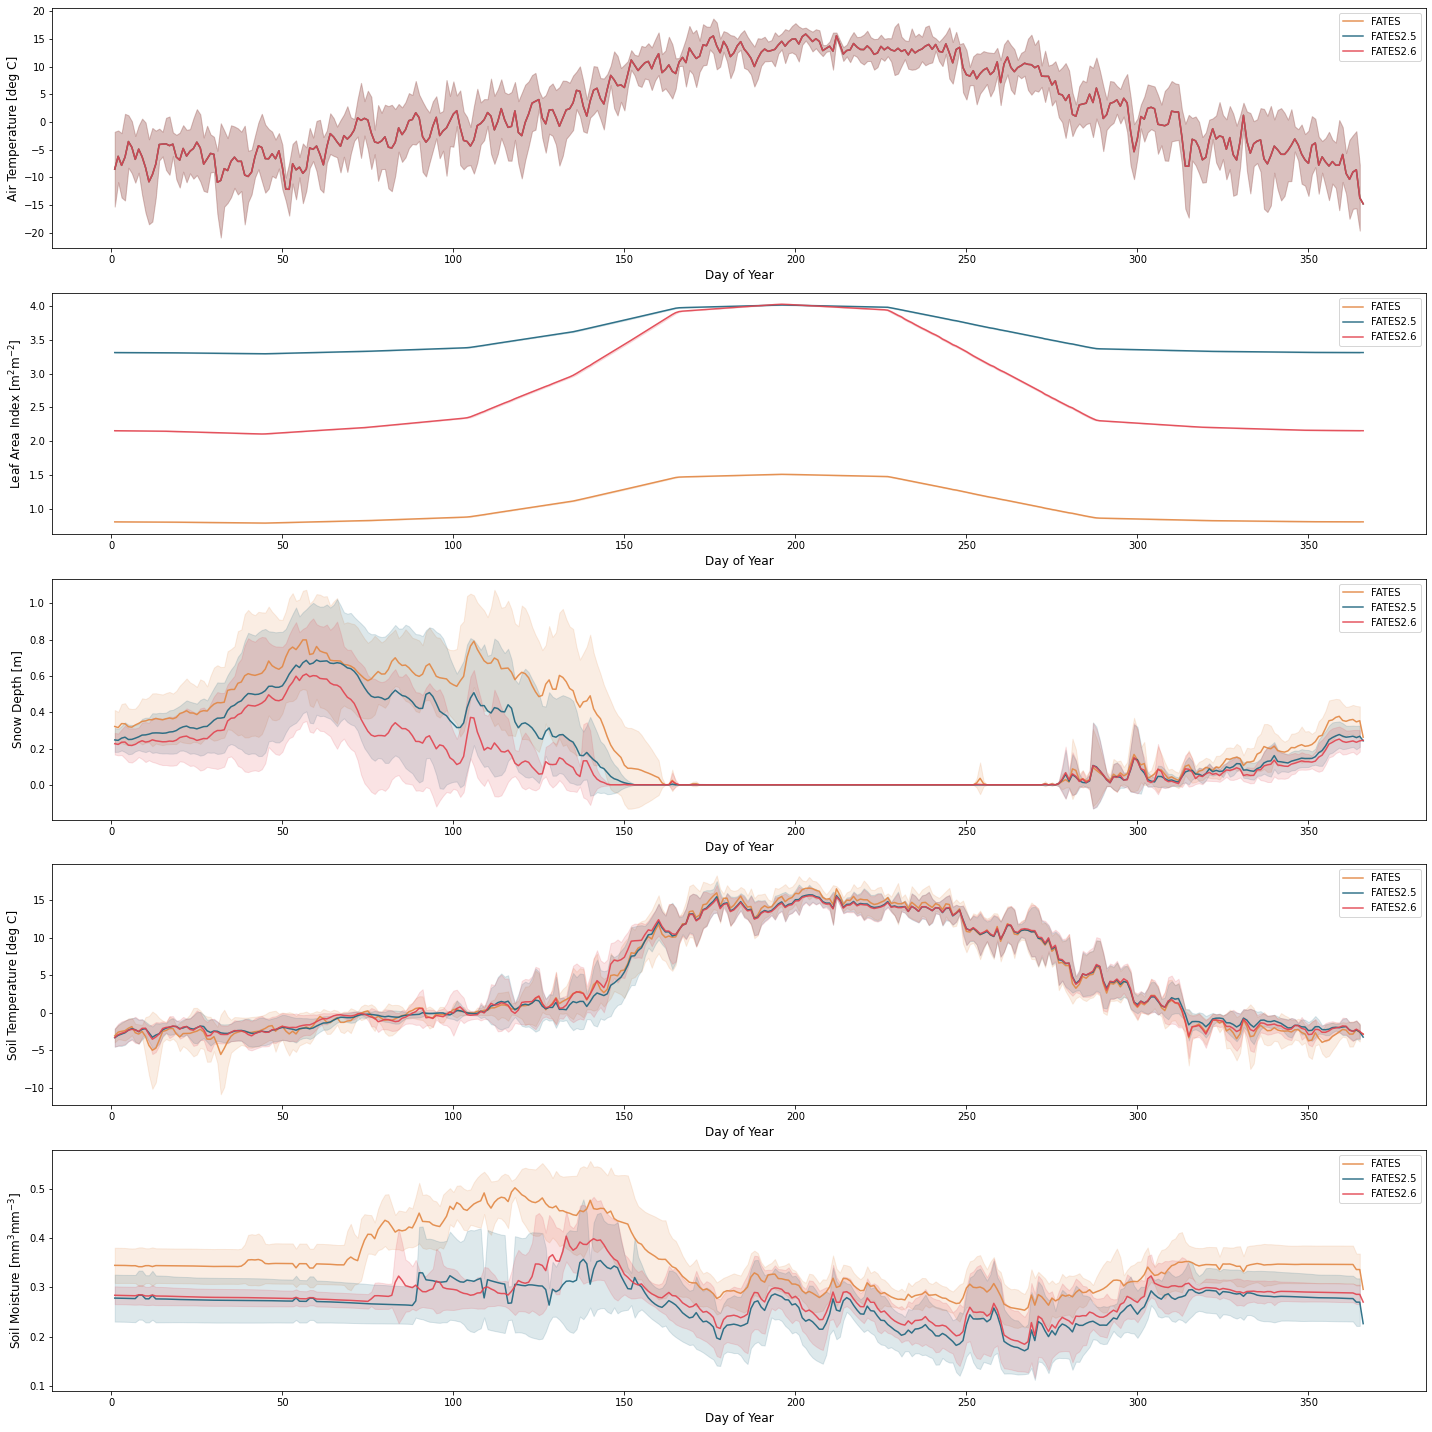

In [113]:
# colorf = '#2EC1D1'
# colorf5 = '#2E70D1'
# colorf6 = '#2ED18F'

# colorc = '#DD3D22'
# colorc5 = '#DD9B22'
# colorc6 = '#DD2264'

plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(5, 1, 1)
plot_var_desc = "Air Temperature"
plot_var_unit= "deg C"

plt.plot(climo1.DOY, climo1['fates_sim_TBOT'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_TBOT'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_TBOT'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_TBOT']-climo1SD['fates_sim_TBOT'], climo1['fates_sim_TBOT']+climo1SD['fates_sim_TBOT'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_TBOT']-climo1SD['fates_sim2.5_TBOT'], climo1['fates_sim2.5_TBOT']+climo1SD['fates_sim2.5_TBOT'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_TBOT']-climo1SD['fates_sim2.6_TBOT'], climo1['fates_sim2.6_TBOT']+climo1SD['fates_sim2.6_TBOT'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_TBOT'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_TBOT'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_TBOT'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_TBOT']-climo1SD['sim_TBOT'], climo1['sim_TBOT']+climo1SD['sim_TBOT'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_TBOT']-climo1SD['sim2.5_TBOT'], climo1['sim2.5_TBOT']+climo1SD['sim2.5_TBOT'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_TBOT']-climo1SD['sim2.6_TBOT'], climo1['sim2.6_TBOT']+climo1SD['sim2.6_TBOT'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 2)
plot_var_desc = "Leaf Area Index"
plot_var_unit= "$\mathrm{m^{2}  m^{-2}}$"

plt.plot(climo1.DOY, climo1['fates_sim_ELAI'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_ELAI'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_ELAI'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_ELAI']-climo1SD['fates_sim_ELAI'], climo1['fates_sim_ELAI']+climo1SD['fates_sim_ELAI'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_ELAI']-climo1SD['fates_sim2.5_ELAI'], climo1['fates_sim2.5_ELAI']+climo1SD['fates_sim2.5_ELAI'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_ELAI']-climo1SD['fates_sim2.6_ELAI'], climo1['fates_sim2.6_ELAI']+climo1SD['fates_sim2.6_ELAI'],alpha=0.15, color = colorf6)


# plt.plot(climo1.DOY, climo1['sim_ELAI'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_ELAI'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_ELAI'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_ELAI']-climo1SD['sim_ELAI'], climo1['sim_ELAI']+climo1SD['sim_ELAI'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_ELAI']-climo1SD['sim2.5_ELAI'], climo1['sim2.5_ELAI']+climo1SD['sim2.5_ELAI'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_ELAI']-climo1SD['sim2.6_ELAI'], climo1['sim2.6_ELAI']+climo1SD['sim2.6_ELAI'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 3)
plot_var_desc = "Snow Depth"
plot_var_unit= "m"

plt.plot(climo1.DOY, climo1['fates_sim_SNOW_DEPTH'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_SNOW_DEPTH'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_SNOW_DEPTH'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_SNOW_DEPTH']-climo1SD['fates_sim_SNOW_DEPTH'], climo1['fates_sim_SNOW_DEPTH']+climo1SD['fates_sim_SNOW_DEPTH'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_SNOW_DEPTH']-climo1SD['fates_sim2.5_SNOW_DEPTH'], climo1['fates_sim2.5_SNOW_DEPTH']+climo1SD['fates_sim2.5_SNOW_DEPTH'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_SNOW_DEPTH']-climo1SD['fates_sim2.6_SNOW_DEPTH'], climo1['fates_sim2.6_SNOW_DEPTH']+climo1SD['fates_sim2.6_SNOW_DEPTH'],alpha=0.15, color = colorf6)


# plt.plot(climo1.DOY, climo1['sim_SNOW_DEPTH'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_SNOW_DEPTH'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_SNOW_DEPTH'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_SNOW_DEPTH']-climo1SD['sim_SNOW_DEPTH'], climo1['sim_SNOW_DEPTH']+climo1SD['sim_SNOW_DEPTH'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_SNOW_DEPTH']-climo1SD['sim2.5_SNOW_DEPTH'], climo1['sim2.5_SNOW_DEPTH']+climo1SD['sim2.5_SNOW_DEPTH'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_SNOW_DEPTH']-climo1SD['sim2.6_SNOW_DEPTH'], climo1['sim2.6_SNOW_DEPTH']+climo1SD['sim2.6_SNOW_DEPTH'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()




plt.subplot(5, 1, 4)
plot_var_desc = "Soil Temperature"
plot_var_unit= "deg C"

plt.plot(climo1.DOY, climo1['fates_sim_TSOI'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_TSOI'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_TSOI'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_TSOI']-climo1SD['fates_sim_TSOI'], climo1['fates_sim_TSOI']+climo1SD['fates_sim_TSOI'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_TSOI']-climo1SD['fates_sim2.5_TSOI'], climo1['fates_sim2.5_TSOI']+climo1SD['fates_sim2.5_TSOI'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_TSOI']-climo1SD['fates_sim2.6_TSOI'], climo1['fates_sim2.6_TSOI']+climo1SD['fates_sim2.6_TSOI'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_TSOI'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_TSOI'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_TSOI'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_TSOI']-climo1SD['sim_TSOI'], climo1['sim_TSOI']+climo1SD['sim_TSOI'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_TSOI']-climo1SD['sim2.5_TSOI'], climo1['sim2.5_TSOI']+climo1SD['sim2.5_TSOI'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_TSOI']-climo1SD['sim2.6_TSOI'], climo1['sim2.6_TSOI']+climo1SD['sim2.6_TSOI'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 5)
plot_var_desc = "Soil Moisture"
plot_var_unit= "$\mathrm{mm^{3}  mm^{-3}}$"

plt.plot(climo1.DOY, climo1['fates_sim_H2OSOI'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_H2OSOI'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_H2OSOI'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_H2OSOI']-climo1SD['fates_sim_H2OSOI'], climo1['fates_sim_H2OSOI']+climo1SD['fates_sim_H2OSOI'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_H2OSOI']-climo1SD['fates_sim2.5_H2OSOI'], climo1['fates_sim2.5_H2OSOI']+climo1SD['fates_sim2.5_H2OSOI'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_H2OSOI']-climo1SD['fates_sim2.6_H2OSOI'], climo1['fates_sim2.6_H2OSOI']+climo1SD['fates_sim2.6_H2OSOI'],alpha=0.15, color = colorf6)


# plt.plot(climo1.DOY, climo1['sim_H2OSOI'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_H2OSOI'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_H2OSOI'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_H2OSOI']-climo1SD['sim_H2OSOI'], climo1['sim_H2OSOI']+climo1SD['sim_H2OSOI'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_H2OSOI']-climo1SD['sim2.5_H2OSOI'], climo1['sim2.5_H2OSOI']+climo1SD['sim2.5_H2OSOI'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_H2OSOI']-climo1SD['sim2.6_H2OSOI'], climo1['sim2.6_H2OSOI']+climo1SD['sim2.6_H2OSOI'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates_g.png')
# plt.savefig('/glade/scratch/nict/lai__clm_g.png')
plt.show()

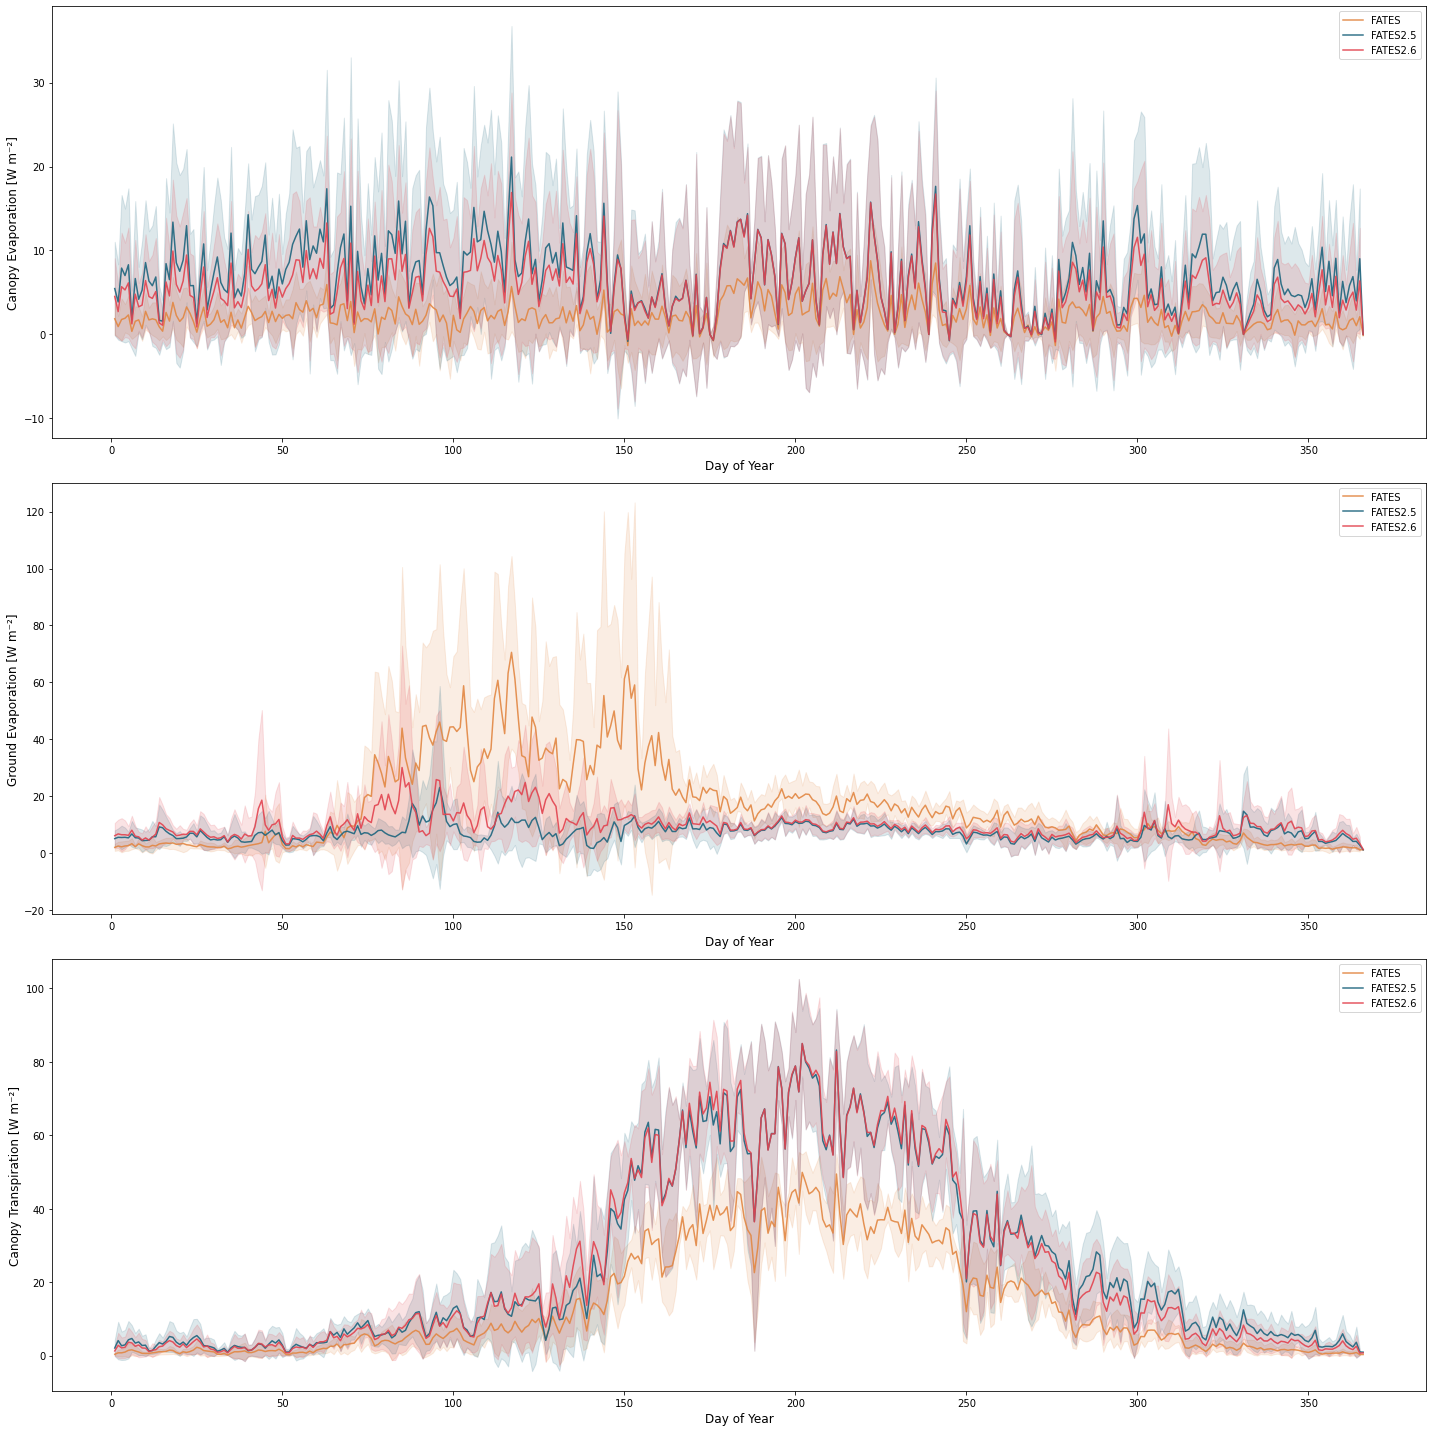

In [115]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(3, 1, 1)
plot_var_desc = "Canopy Evaporation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FCEV'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_FCEV'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_FCEV'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_FCEV']-climo1SD['fates_sim_FCEV'], climo1['fates_sim_FCEV']+climo1SD['fates_sim_FCEV'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FCEV']-climo1SD['fates_sim2.5_FCEV'], climo1['fates_sim2.5_FCEV']+climo1SD['fates_sim2.5_FCEV'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_FCEV']-climo1SD['fates_sim2.6_FCEV'], climo1['fates_sim2.6_FCEV']+climo1SD['fates_sim2.6_FCEV'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_FCEV'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_FCEV'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_FCEV'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_FCEV']-climo1SD['sim_FCEV'], climo1['sim_FCEV']+climo1SD['sim_FCEV'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_FCEV']-climo1SD['sim2.5_FCEV'], climo1['sim2.5_FCEV']+climo1SD['sim2.5_FCEV'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_FCEV']-climo1SD['sim2.6_FCEV'], climo1['sim2.6_FCEV']+climo1SD['sim2.6_FCEV'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 2)
plot_var_desc = "Ground Evaporation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FGEV'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_FGEV'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_FGEV'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_FGEV']-climo1SD['fates_sim_FGEV'], climo1['fates_sim_FGEV']+climo1SD['fates_sim_FGEV'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FGEV']-climo1SD['fates_sim2.5_FGEV'], climo1['fates_sim2.5_FGEV']+climo1SD['fates_sim2.5_FGEV'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_FGEV']-climo1SD['fates_sim2.6_FGEV'], climo1['fates_sim2.6_FGEV']+climo1SD['fates_sim2.6_FGEV'],alpha=0.15, color = colorf6)


# plt.plot(climo1.DOY, climo1['sim_FGEV'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_FGEV'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_FGEV'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_FGEV']-climo1SD['sim_FGEV'], climo1['sim_FGEV']+climo1SD['sim_FGEV'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_FGEV']-climo1SD['sim2.5_FGEV'], climo1['sim2.5_FGEV']+climo1SD['sim2.5_FGEV'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_FGEV']-climo1SD['sim2.6_FGEV'], climo1['sim2.6_FGEV']+climo1SD['sim2.6_FGEV'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(3, 1, 3)
plot_var_desc = "Canopy Transpiration"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FCTR'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_FCTR'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_FCTR'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_FCTR']-climo1SD['fates_sim_FCTR'], climo1['fates_sim_FCTR']+climo1SD['fates_sim_FCTR'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FCTR']-climo1SD['fates_sim2.5_FCTR'], climo1['fates_sim2.5_FCTR']+climo1SD['fates_sim2.5_FCTR'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_FCTR']-climo1SD['fates_sim2.6_FCTR'], climo1['fates_sim2.6_FCTR']+climo1SD['fates_sim2.6_FCTR'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_FCTR'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_FCTR'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_FCTR'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_FCTR']-climo1SD['sim_FCTR'], climo1['sim_FCTR']+climo1SD['sim_FCTR'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_FCTR']-climo1SD['sim2.5_FCTR'], climo1['sim2.5_FCTR']+climo1SD['sim2.5_FCTR'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_FCTR']-climo1SD['sim2.6_FCTR'], climo1['sim2.6_FCTR']+climo1SD['sim2.6_FCTR'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates_et.png')
# plt.savefig('/glade/scratch/nict/lai__clm_et.png')
plt.show()

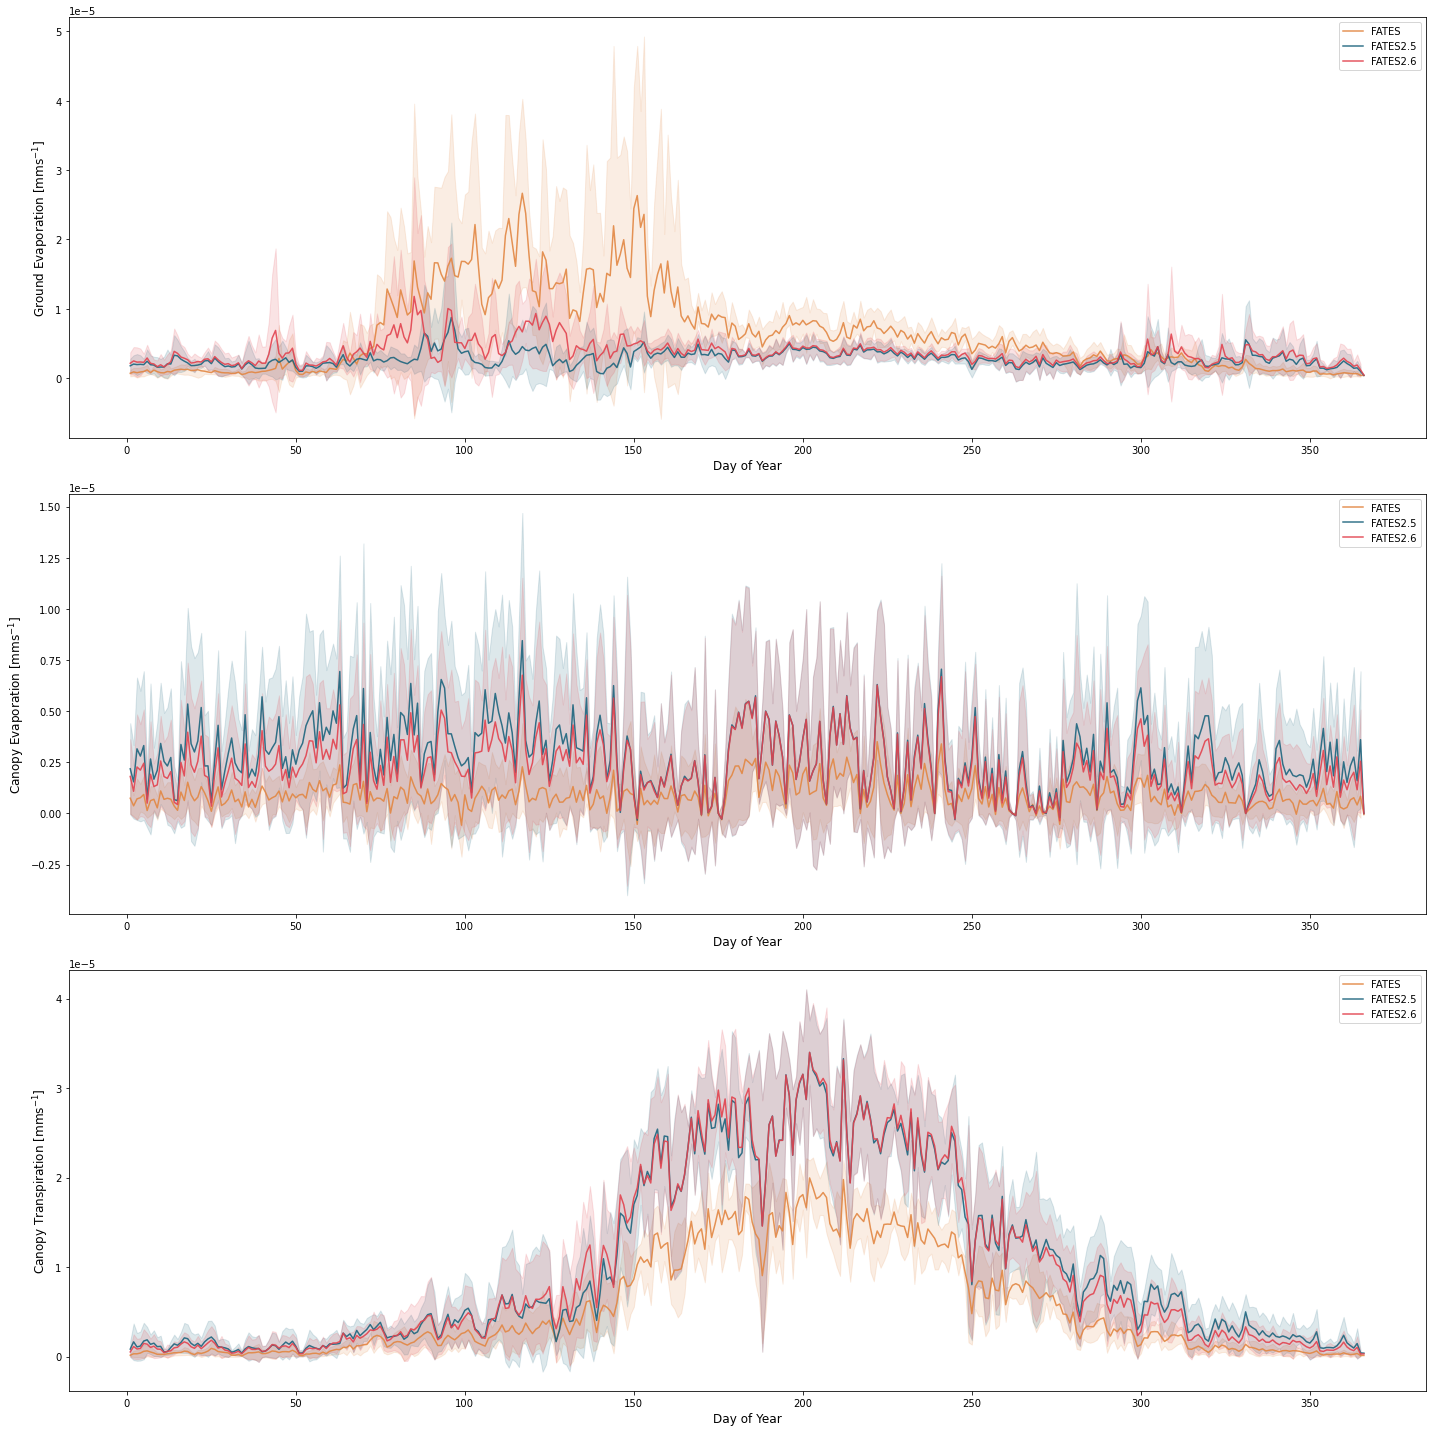

In [117]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(3, 1, 1)
plot_var_desc = "Ground Evaporation"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QSOIL'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_QSOIL'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_QSOIL'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QSOIL']-climo1SD['fates_sim_QSOIL'], climo1['fates_sim_QSOIL']+climo1SD['fates_sim_QSOIL'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_QSOIL']-climo1SD['fates_sim2.5_QSOIL'], climo1['fates_sim2.5_QSOIL']+climo1SD['fates_sim2.5_QSOIL'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_QSOIL']-climo1SD['fates_sim2.6_QSOIL'], climo1['fates_sim2.6_QSOIL']+climo1SD['fates_sim2.6_QSOIL'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_QSOIL'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_QSOIL'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_QSOIL'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_QSOIL']-climo1SD['sim_QSOIL'], climo1['sim_QSOIL']+climo1SD['sim_QSOIL'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_QSOIL']-climo1SD['sim2.5_QSOIL'], climo1['sim2.5_QSOIL']+climo1SD['sim2.5_QSOIL'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_QSOIL']-climo1SD['sim2.6_QSOIL'], climo1['sim2.6_QSOIL']+climo1SD['sim2.6_QSOIL'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 2)
plot_var_desc = "Canopy Evaporation"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QVEGE'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_QVEGE'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_QVEGE'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QVEGE']-climo1SD['fates_sim_QVEGE'], climo1['fates_sim_QVEGE']+climo1SD['fates_sim_QVEGE'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_QVEGE']-climo1SD['fates_sim2.5_QVEGE'], climo1['fates_sim2.5_QVEGE']+climo1SD['fates_sim2.5_QVEGE'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_QVEGE']-climo1SD['fates_sim2.6_QVEGE'], climo1['fates_sim2.6_QVEGE']+climo1SD['fates_sim2.6_QVEGE'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_QVEGE'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_QVEGE'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_QVEGE'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_QVEGE']-climo1SD['sim_QVEGE'], climo1['sim_QVEGE']+climo1SD['sim_QVEGE'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_QVEGE']-climo1SD['sim2.5_QVEGE'], climo1['sim2.5_QVEGE']+climo1SD['sim2.5_QVEGE'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_QVEGE']-climo1SD['sim2.6_QVEGE'], climo1['sim2.6_QVEGE']+climo1SD['sim2.6_QVEGE'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 3)
plot_var_desc = "Canopy Transpiration"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QVEGT'], color = colorf, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.5_QVEGT'], color = colorf5, label="FATES2.5", alpha = 0.9)
plt.plot(climo1.DOY, climo1['fates_sim2.6_QVEGT'], color = colorf6, label="FATES2.6", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QVEGT']-climo1SD['fates_sim_QVEGT'], climo1['fates_sim_QVEGT']+climo1SD['fates_sim_QVEGT'],alpha=0.15, color = colorf)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_QVEGT']-climo1SD['fates_sim2.5_QVEGT'], climo1['fates_sim2.5_QVEGT']+climo1SD['fates_sim2.5_QVEGT'],alpha=0.15, color = colorf5)
plt.fill_between(climo1.DOY, climo1['fates_sim2.6_QVEGT']-climo1SD['fates_sim2.6_QVEGT'], climo1['fates_sim2.6_QVEGT']+climo1SD['fates_sim2.6_QVEGT'],alpha=0.15, color = colorf6)

# plt.plot(climo1.DOY, climo1['sim_QVEGT'], color = colorc,label="CLM", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.5_QVEGT'], color = colorc5,label="CLM2.5", alpha = 0.9)
# plt.plot(climo1.DOY, climo1['sim2.6_QVEGT'], color = colorc6,label="CLM2.6", alpha = 0.9)
# plt.fill_between(climo1.DOY, climo1['sim_QVEGT']-climo1SD['sim_QVEGT'], climo1['sim_QVEGT']+climo1SD['sim_QVEGT'] ,alpha=0.15, color = colorc)
# plt.fill_between(climo1.DOY, climo1['sim2.5_QVEGT']-climo1SD['sim2.5_QVEGT'], climo1['sim2.5_QVEGT']+climo1SD['sim2.5_QVEGT'] ,alpha=0.15, color = colorc5)
# plt.fill_between(climo1.DOY, climo1['sim2.6_QVEGT']-climo1SD['sim2.6_QVEGT'], climo1['sim2.6_QVEGT']+climo1SD['sim2.6_QVEGT'] ,alpha=0.15, color = colorc6)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates_et2.png')
# plt.savefig('/glade/scratch/nict/lai__clm_et2.png')
plt.show()

# Plotting LAI 2.5 runs

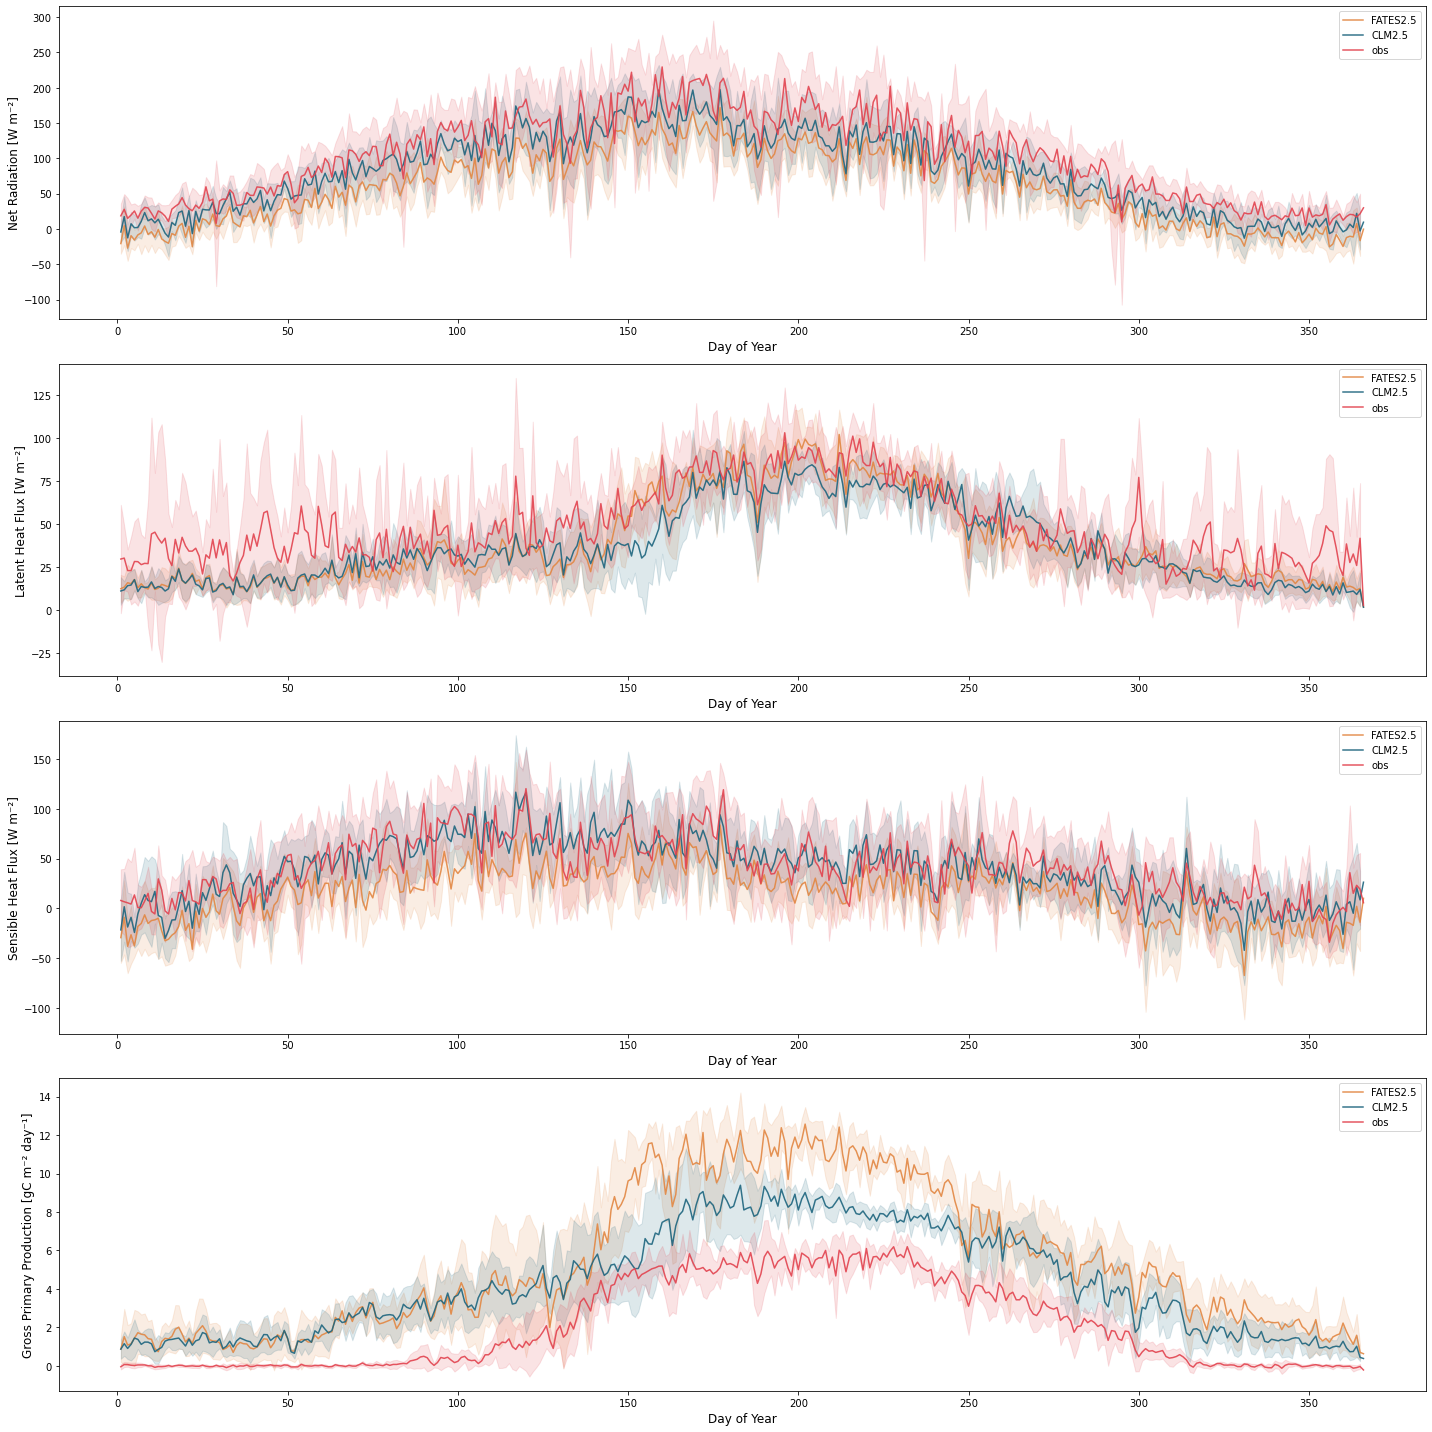

In [120]:
color1='#e28743'
color2='#1d657e'
color3='#E2434F'

plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(4, 1, 1)
plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim2.5_Rnet'], color = color1, label="FATES2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_Rnet']-climo1SD['fates_sim2.5_Rnet'], climo1['fates_sim2.5_Rnet']+climo1SD['fates_sim2.5_Rnet'],alpha=0.15, color = color1)

plt.plot(climo1.DOY, climo1['sim2.5_Rnet'], color = color2,label="CLM2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['sim2.5_Rnet']-climo1SD['sim2.5_Rnet'], climo1['sim2.5_Rnet']+climo1SD['sim2.5_Rnet'] ,alpha=0.15, color = color2)

plt.plot(climo1.DOY, climo1['nr'], color = color3, label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['nr']-climo1SD['nr'], climo1['nr']+climo1SD['nr'],alpha=0.15, color = color3)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 2)
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim2.5_EFLX_LH_TOT'], color = color1, label="FATES2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_EFLX_LH_TOT']-climo1SD['fates_sim2.5_EFLX_LH_TOT'], climo1['fates_sim2.5_EFLX_LH_TOT']+climo1SD['fates_sim2.5_EFLX_LH_TOT'],alpha=0.15, color = color1)

plt.plot(climo1.DOY, climo1['sim2.5_EFLX_LH_TOT'], color = color2,label="CLM2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['sim2.5_EFLX_LH_TOT']-climo1SD['sim2.5_EFLX_LH_TOT'], climo1['sim2.5_EFLX_LH_TOT']+climo1SD['sim2.5_EFLX_LH_TOT'] ,alpha=0.15, color = color2)

plt.plot(climo1.DOY, climo1['le_mean'], color = color3, label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['le_mean']-climo1SD['le_mean'], climo1['le_mean']+climo1SD['le_mean'],alpha=0.15, color = color3)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()




plt.subplot(4, 1, 3)
plot_var_desc = "Sensible Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim2.5_FSH'], color = color1, label="FATES2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FSH']-climo1SD['fates_sim2.5_FSH'], climo1['fates_sim2.5_FSH']+climo1SD['fates_sim2.5_FSH'],alpha=0.15, color = color1)

plt.plot(climo1.DOY, climo1['sim2.5_FSH'], color = color2,label="CLM2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['sim2.5_FSH']-climo1SD['sim2.5_FSH'], climo1['sim2.5_FSH']+climo1SD['sim2.5_FSH'] ,alpha=0.15, color = color2)

plt.plot(climo1.DOY, climo1['h'], color = color3, label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['h']-climo1SD['h'], climo1['h']+climo1SD['h'],alpha=0.15, color = color3)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(4, 1, 4)
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"

plt.plot(climo1.DOY, climo1['fates_sim2.5_FATES_GPP'], color = color1, label="FATES2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim2.5_FATES_GPP']-climo1SD['fates_sim2.5_FATES_GPP'], climo1['fates_sim2.5_FATES_GPP']+climo1SD['fates_sim2.5_FATES_GPP'],alpha=0.15, color = color1)

plt.plot(climo1.DOY, climo1['sim2.5_FPSN'], color = color2,label="CLM2.5", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['sim2.5_FPSN']-climo1SD['sim2.5_FPSN'], climo1['sim2.5_FPSN']+climo1SD['sim2.5_FPSN'] ,alpha=0.15, color = color2)

plt.plot(climo1.DOY, climo1['gpp_mean'], color = color3, label="obs", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['gpp_mean']-climo1SD['gpp_mean'], climo1['gpp_mean']+climo1SD['gpp_mean'],alpha=0.15, color = color3)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.tight_layout()
plt.savefig('/glade/scratch/nict/lai_fates2.5_obs.png')
plt.show()

## Plotting one 

In [75]:
df1 = pd.read_csv('/glade/scratch/nict/mean_daily_US-NR1_test_fatesSP.csv')

df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df1 = df1.set_index('time')

# extract relevant variables and drop NANs
# df1 = df1[['sim_GPP','sim_NEE','sim_Rnet','sim_EFLX_LH_TOT','nr','gpp','LE','nee','DOY','time2']].copy()


# remove outliers for net radiation 
# upper_outlier_nr, lower_outlier_nr = df1.nr.quantile(.98), df1.nr.quantile(.02)
# df1 = df1[(df1.nr < upper_outlier_nr) & (df1.nr > lower_outlier_nr)]

# remove extreme values for net radiation 
df1 = df1[(df1.nr >= -200)]

# df1 = df1.dropna()
df1

local_date     sim_QVEGT     sim_QVEGE     sim_QSOIL  sim_RAIN  \
time                                                                         
2010-01-01  2010-01-01  4.846371e-07  1.039172e-06  4.533578e-07       0.0   
2010-01-02  2010-01-02  3.191878e-07  1.220768e-06  4.123567e-07       0.0   
2010-01-03  2010-01-03  2.854196e-07  7.848963e-07  4.521671e-07       0.0   
2010-01-04  2010-01-04  4.266065e-07  1.437216e-06  6.400430e-07       0.0   
2010-01-05  2010-01-05  2.806450e-07  1.573912e-06  4.527619e-07       0.0   
...                ...           ...           ...           ...       ...   
2015-12-26  2015-12-26  3.131650e-07 -2.870263e-07 -1.371218e-07       0.0   
2015-12-27  2015-12-27  4.496382e-07  1.155643e-06  5.147826e-07       0.0   
2015-12-28  2015-12-28  2.785762e-07  7.062222e-07  2.986385e-07       0.0   
2015-12-29  2015-12-29  2.290897e-07  2.345617e-08  4.205387e-07       0.0   
2015-12-30  2015-12-30           NaN           NaN           NaN       NaN   

            sim_SNOW  sim_Vcmx25Z  sim_ELAI  sim_FCEV  sim_FCTR  ...  \
time                                                             ...   
2010-01-01  0.000000    46.054817  0.810829  2.598970  1.212077  ...   
2010-01-02  0.000052    45.783000  0.810671  3.053140  0.798289  ...   
2010-01-03  0.000005    45.374226  0.810513  1.963026  0.713834  ...   
2010-01-04  0.000001    45.420082  0.810354  3.594479  1.066943  ...   
2010-01-05  0.000034    45.307655  0.810196  3.936354  0.701893  ...   
...              ...          ...       ...       ...       ...  ...   
2015-12-26  0.000000    42.264190  0.811621 -0.717853  0.783226  ...   
2015-12-27  0.000000    41.873390  0.811463  2.890263  1.124545  ...   
2015-12-28  0.000000    41.943478  0.811304  1.766262  0.696719  ...   
2015-12-29  0.000000    42.308594  0.811146  0.058664  0.572953  ...   
2015-12-30       NaN          NaN       NaN       NaN       NaN  ...   

                  day  hour  local_hour       nee       gpp         LE  \
time                                                                     
2010-01-01   1.583333  11.5        11.5  0.318833 -0.008748  20.730396   
2010-01-02   2.583333  11.5        11.5  0.324372 -0.043569  55.009900   
2010-01-03   3.583333  11.5        11.5  0.287868 -0.031261  19.894917   
2010-01-04   4.583333  11.5        11.5  0.238265  0.055113  15.456104   
2010-01-05   5.583333  11.5        11.5  0.318897 -0.035808  44.757006   
...               ...   ...         ...       ...       ...        ...   
2015-12-26  26.583333  11.5        11.5  0.393147 -0.158086   2.456344   
2015-12-27  27.583333  11.5        11.5  0.357277 -0.090160  64.301291   
2015-12-28  28.583333  11.5        11.5  0.321485 -0.123250  44.368957   
2015-12-29  29.583333  11.5        11.5  0.528801 -0.420420  14.372322   
2015-12-30        NaN   NaN        11.5  0.281605 -0.257438  13.504245   

                    h         nr      time2  DOY  
time                                              
2010-01-01  11.781483  26.588375 2010-01-01    1  
2010-01-02 -20.226875  24.845417 2010-01-02    2  
2010-01-03  -4.329604   9.376458 2010-01-03    3  
2010-01-04   9.440417  32.030000 2010-01-04    4  
2010-01-05 -23.238042  23.743125 2010-01-05    5  
...               ...        ...        ...  ...  
2015-12-26   0.685771  10.183229 2015-12-26  360  
2015-12-27 -53.836146  17.830417 2015-12-27  361  
2015-12-28   8.091146  35.008333 2015-12-28  362  
2015-12-29  24.887898  47.862083 2015-12-29  363  
2015-12-30  33.480417  44.567708 2015-12-30  364  

[2061 rows x 58 columns]

In [76]:
# Group by DOY and calculate mean and std
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()

climo1.var()

sim_QVEGT                4.257594e-11
sim_QVEGE                4.411818e-13
sim_QSOIL                2.014170e-11
sim_RAIN                 4.583457e-10
sim_SNOW                 6.858043e-10
sim_Vcmx25Z              1.097725e+02
sim_ELAI                 7.327873e-02
sim_FCEV                 2.759593e+00
sim_FCTR                 2.663126e+02
sim_FGEV                 1.361340e+02
sim_FIRA                 2.592582e+02
sim_FSA                  3.816691e+03
sim_FSR                  1.328460e+02
sim_FSDS                 4.492552e+03
sim_FSH                  5.562886e+02
sim_FPSN                 3.632343e+00
sim_H2OSOI               3.624319e-03
sim_SNOW_DEPTH           7.157496e-02
sim_TBOT                 6.348632e+01
sim_TSOI                 5.077096e+01
sim_BTRANMN                       NaN
sim_TV                   6.567013e+01
fates_sim_QVEGT          3.291703e-11
fates_sim_QVEGE          4.120872e-13
fates_sim_QSOIL          3.243337e-11
fates_sim_RAIN           4.583457e-10
fates_sim_SN

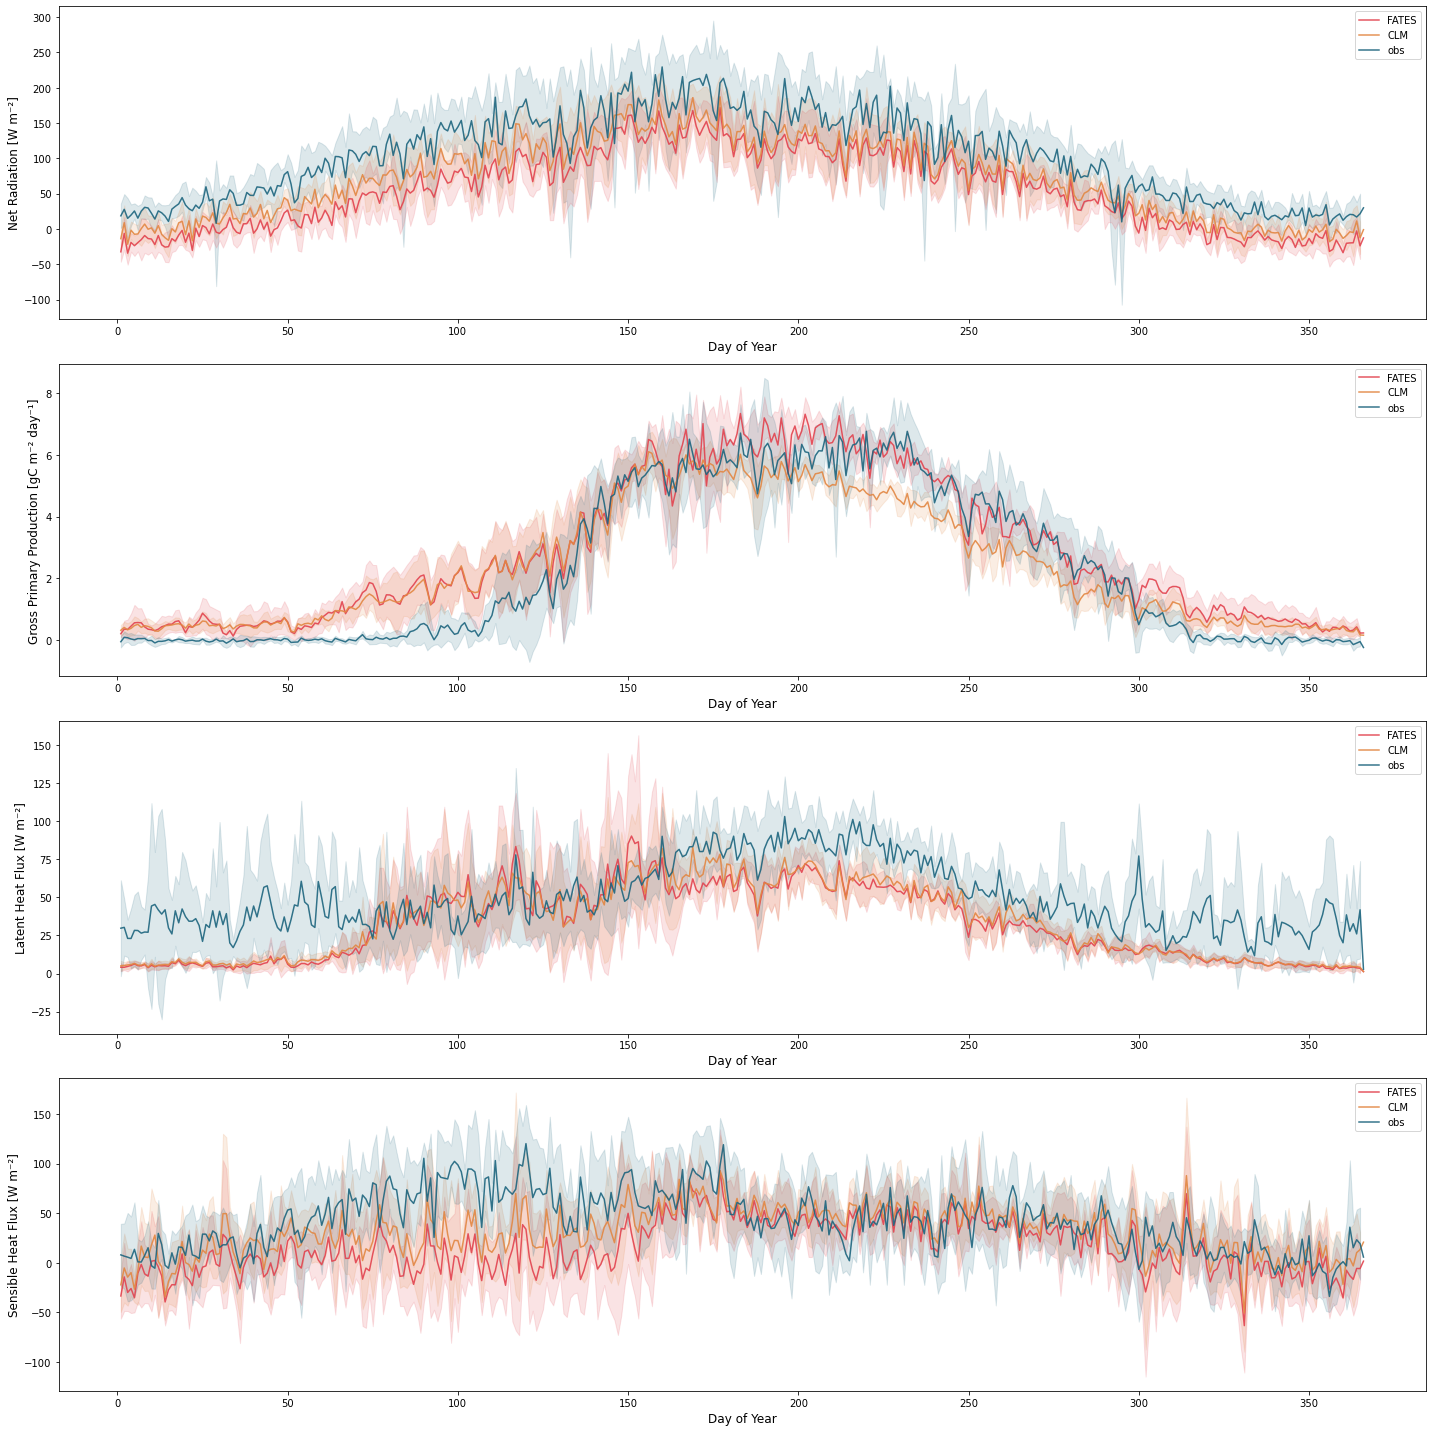

In [81]:
color1='#e28743'
color2='#1d657e'
color3='#E2434F'

plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(4, 1, 1)
plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_Rnet'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_Rnet'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['nr'], color = color2, label="obs", alpha = 0.9)

    
plt.fill_between(climo1.DOY, climo1['nr']-climo1SD['nr'], climo1['nr']+climo1SD['nr'],alpha=0.15, color = color2)    
plt.fill_between(climo1.DOY, climo1['fates_sim_Rnet']-climo1SD['fates_sim_Rnet'], climo1['fates_sim_Rnet']+climo1SD['fates_sim_Rnet'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_Rnet']-climo1SD['sim_Rnet'], climo1['sim_Rnet']+climo1SD['sim_Rnet'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 2)
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"

plt.plot(climo1.DOY, climo1['fates_sim_FATES_GPP'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FPSN'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['gpp'], color = color2, label="obs", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FATES_GPP']-climo1SD['fates_sim_FATES_GPP'], climo1['fates_sim_FATES_GPP']+climo1SD['fates_sim_FATES_GPP'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_FPSN']-climo1SD['sim_FPSN'], climo1['sim_FPSN']+climo1SD['sim_FPSN'] ,alpha=0.15, color = color1)
plt.fill_between(climo1.DOY, climo1['gpp']-climo1SD['gpp'], climo1['gpp']+climo1SD['gpp'],alpha=0.15, color = color2)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 3)
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_EFLX_LH_TOT'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_EFLX_LH_TOT'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['LE'], color = color2, label="obs", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_EFLX_LH_TOT']-climo1SD['fates_sim_EFLX_LH_TOT'], climo1['fates_sim_EFLX_LH_TOT']+climo1SD['fates_sim_EFLX_LH_TOT'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_EFLX_LH_TOT']-climo1SD['sim_EFLX_LH_TOT'], climo1['sim_EFLX_LH_TOT']+climo1SD['sim_EFLX_LH_TOT'] ,alpha=0.15, color = color1)
plt.fill_between(climo1.DOY, climo1['LE']-climo1SD['LE'], climo1['LE']+climo1SD['LE'],alpha=0.15, color = color2)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 4)
plot_var_desc = "Sensible Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FSH'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FSH'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['h'], color = color2, label="obs", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FSH']-climo1SD['fates_sim_FSH'], climo1['fates_sim_FSH']+climo1SD['fates_sim_FSH'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_FSH']-climo1SD['sim_FSH'], climo1['sim_FSH']+climo1SD['sim_FSH'] ,alpha=0.15, color = color1)
plt.fill_between(climo1.DOY, climo1['h']-climo1SD['h'], climo1['h']+climo1SD['h'],alpha=0.15, color = color2)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates1.png')
plt.show()

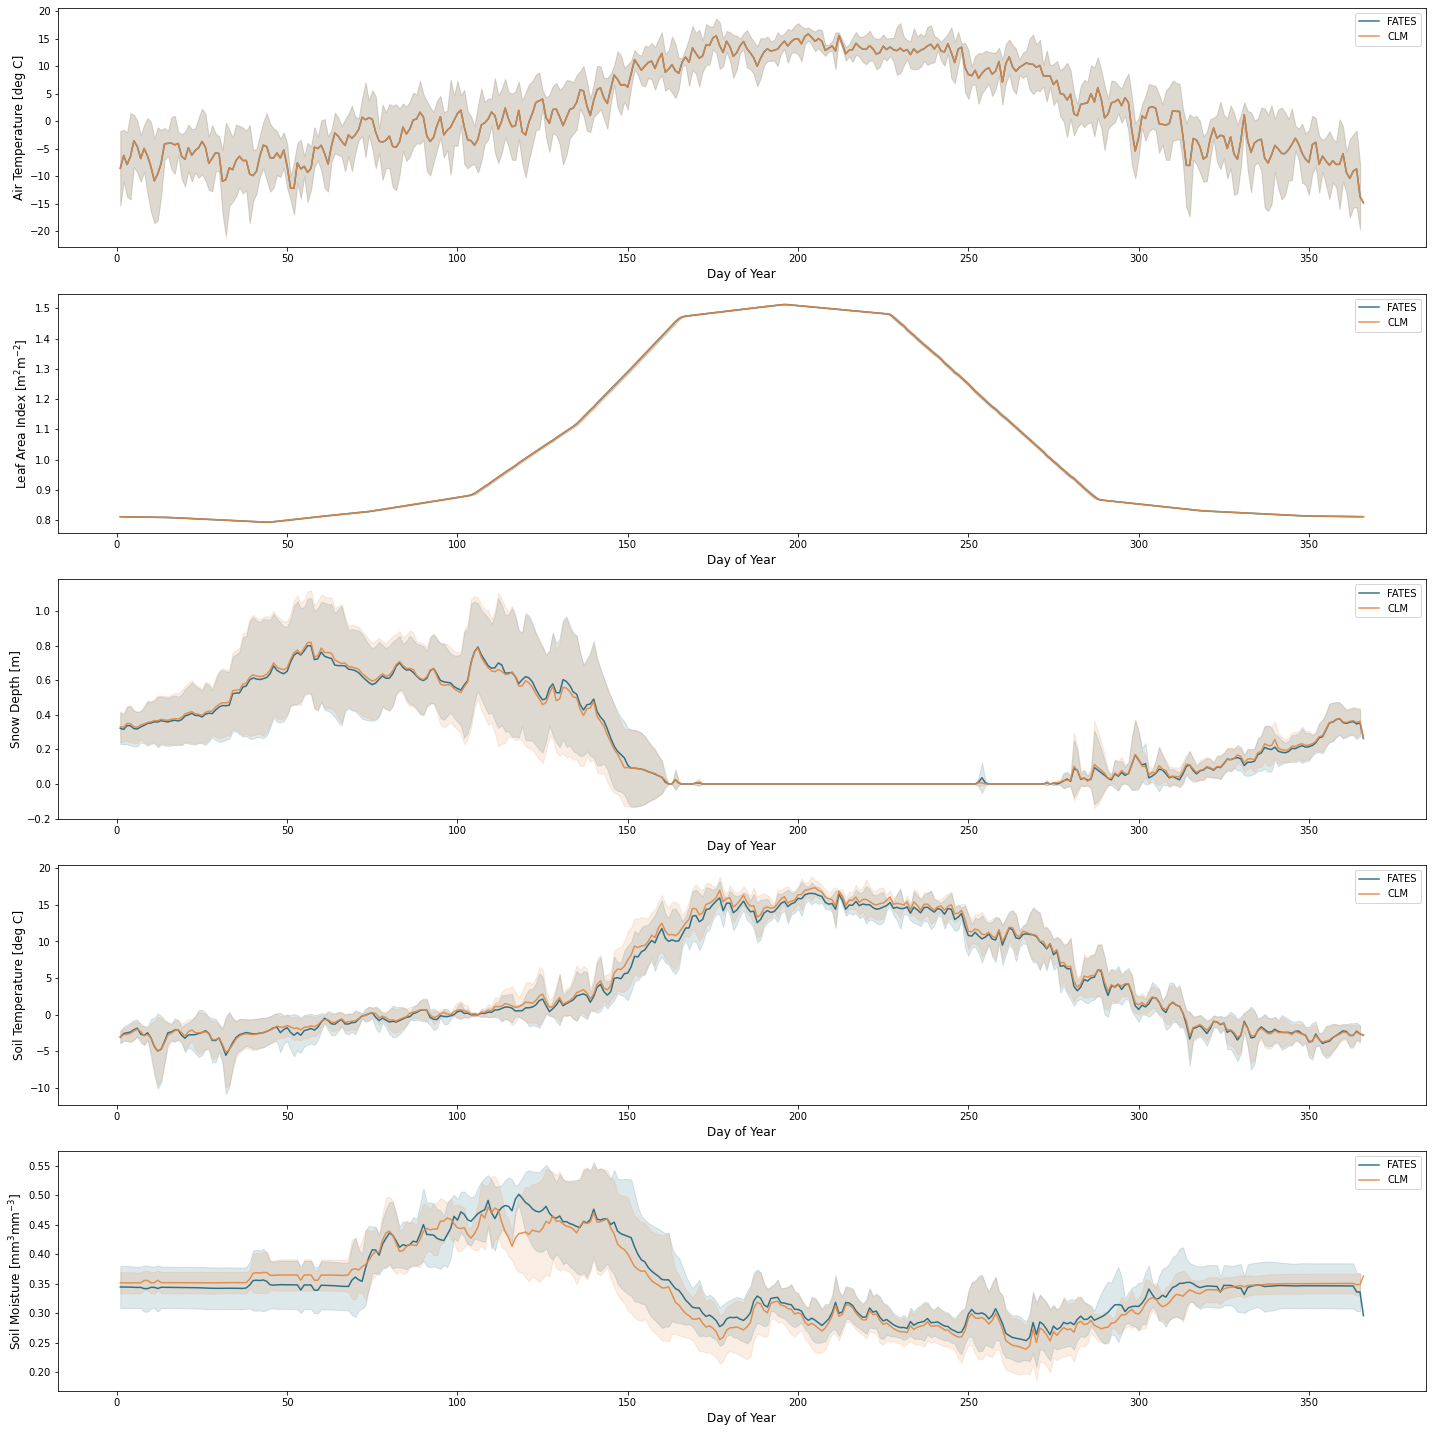

In [82]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(5, 1, 1)
plot_var_desc = "Air Temperature"
plot_var_unit= "deg C"

plt.plot(climo1.DOY, climo1['fates_sim_TBOT'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_TBOT'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_TBOT']-climo1SD['fates_sim_TBOT'], climo1['fates_sim_TBOT']+climo1SD['fates_sim_TBOT'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_TBOT']-climo1SD['sim_TBOT'], climo1['sim_TBOT']+climo1SD['sim_TBOT'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 2)
plot_var_desc = "Leaf Area Index"
plot_var_unit= "$\mathrm{m^{2}  m^{-2}}$"

plt.plot(climo1.DOY, climo1['fates_sim_ELAI'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_ELAI'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_ELAI']-climo1SD['fates_sim_ELAI'], climo1['fates_sim_ELAI']+climo1SD['fates_sim_ELAI'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_ELAI']-climo1SD['sim_ELAI'], climo1['sim_ELAI']+climo1SD['sim_ELAI'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 3)
plot_var_desc = "Snow Depth"
plot_var_unit= "m"

plt.plot(climo1.DOY, climo1['fates_sim_SNOW_DEPTH'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_SNOW_DEPTH'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_SNOW_DEPTH']-climo1SD['fates_sim_SNOW_DEPTH'], climo1['fates_sim_SNOW_DEPTH']+climo1SD['fates_sim_SNOW_DEPTH'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_SNOW_DEPTH']-climo1SD['sim_SNOW_DEPTH'], climo1['sim_SNOW_DEPTH']+climo1SD['sim_SNOW_DEPTH'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()




plt.subplot(5, 1, 4)
plot_var_desc = "Soil Temperature"
plot_var_unit= "deg C"

plt.plot(climo1.DOY, climo1['fates_sim_TSOI'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_TSOI'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_TSOI']-climo1SD['fates_sim_TSOI'], climo1['fates_sim_TSOI']+climo1SD['fates_sim_TSOI'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_TSOI']-climo1SD['sim_TSOI'], climo1['sim_TSOI']+climo1SD['sim_TSOI'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 5)
plot_var_desc = "Soil Moisture"
plot_var_unit= "$\mathrm{mm^{3}  mm^{-3}}$"

plt.plot(climo1.DOY, climo1['fates_sim_H2OSOI'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_H2OSOI'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_H2OSOI']-climo1SD['fates_sim_H2OSOI'], climo1['fates_sim_H2OSOI']+climo1SD['fates_sim_H2OSOI'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_H2OSOI']-climo1SD['sim_H2OSOI'], climo1['sim_H2OSOI']+climo1SD['sim_H2OSOI'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates2.png')
plt.show()

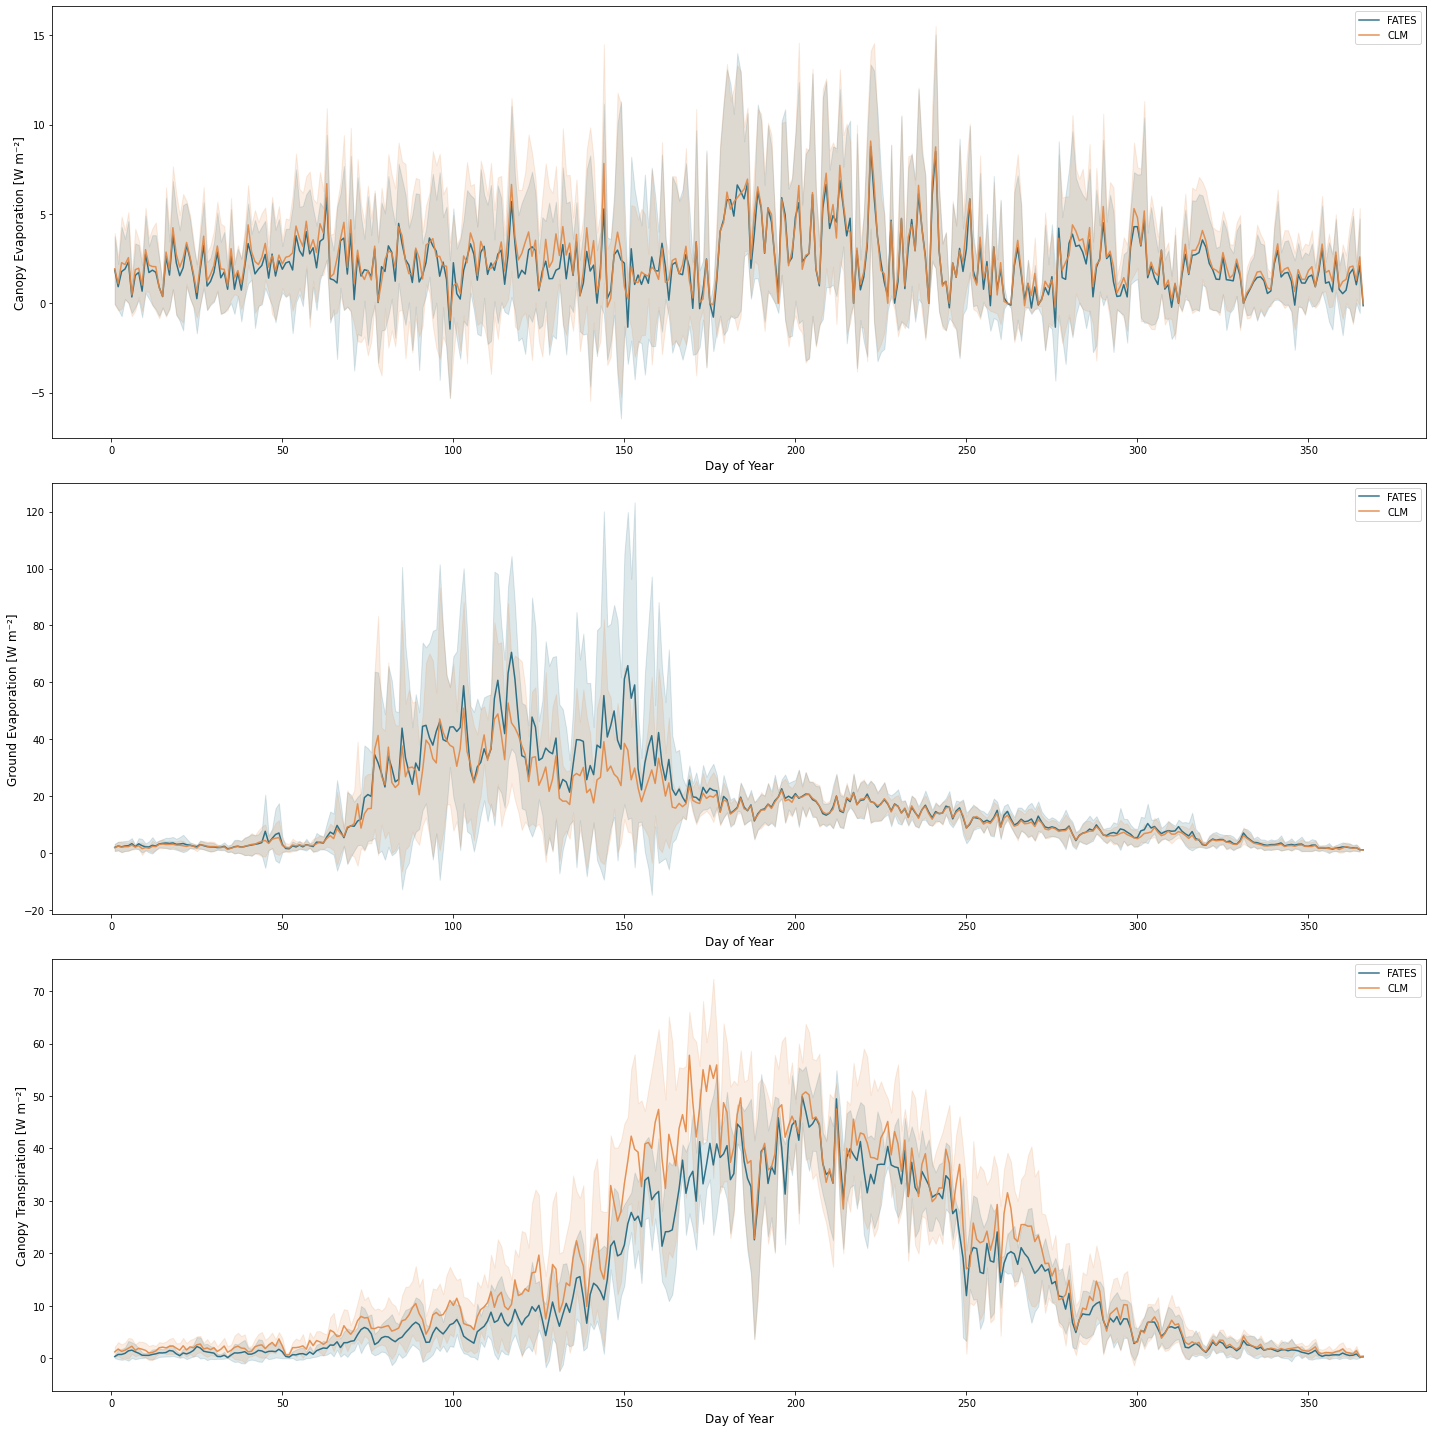

In [83]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(3, 1, 1)
plot_var_desc = "Canopy Evaporation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FCEV'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FCEV'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FCEV']-climo1SD['fates_sim_FCEV'], climo1['fates_sim_FCEV']+climo1SD['fates_sim_FCEV'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_FCEV']-climo1SD['sim_FCEV'], climo1['sim_FCEV']+climo1SD['sim_FCEV'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 2)
plot_var_desc = "Ground Evaporation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FGEV'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FGEV'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FGEV']-climo1SD['fates_sim_FGEV'], climo1['fates_sim_FGEV']+climo1SD['fates_sim_FGEV'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_FGEV']-climo1SD['sim_FGEV'], climo1['sim_FGEV']+climo1SD['sim_FGEV'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(3, 1, 3)
plot_var_desc = "Canopy Transpiration"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FCTR'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FCTR'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FCTR']-climo1SD['fates_sim_FCTR'], climo1['fates_sim_FCTR']+climo1SD['fates_sim_FCTR'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_FCTR']-climo1SD['sim_FCTR'], climo1['sim_FCTR']+climo1SD['sim_FCTR'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates3.png')
plt.show()

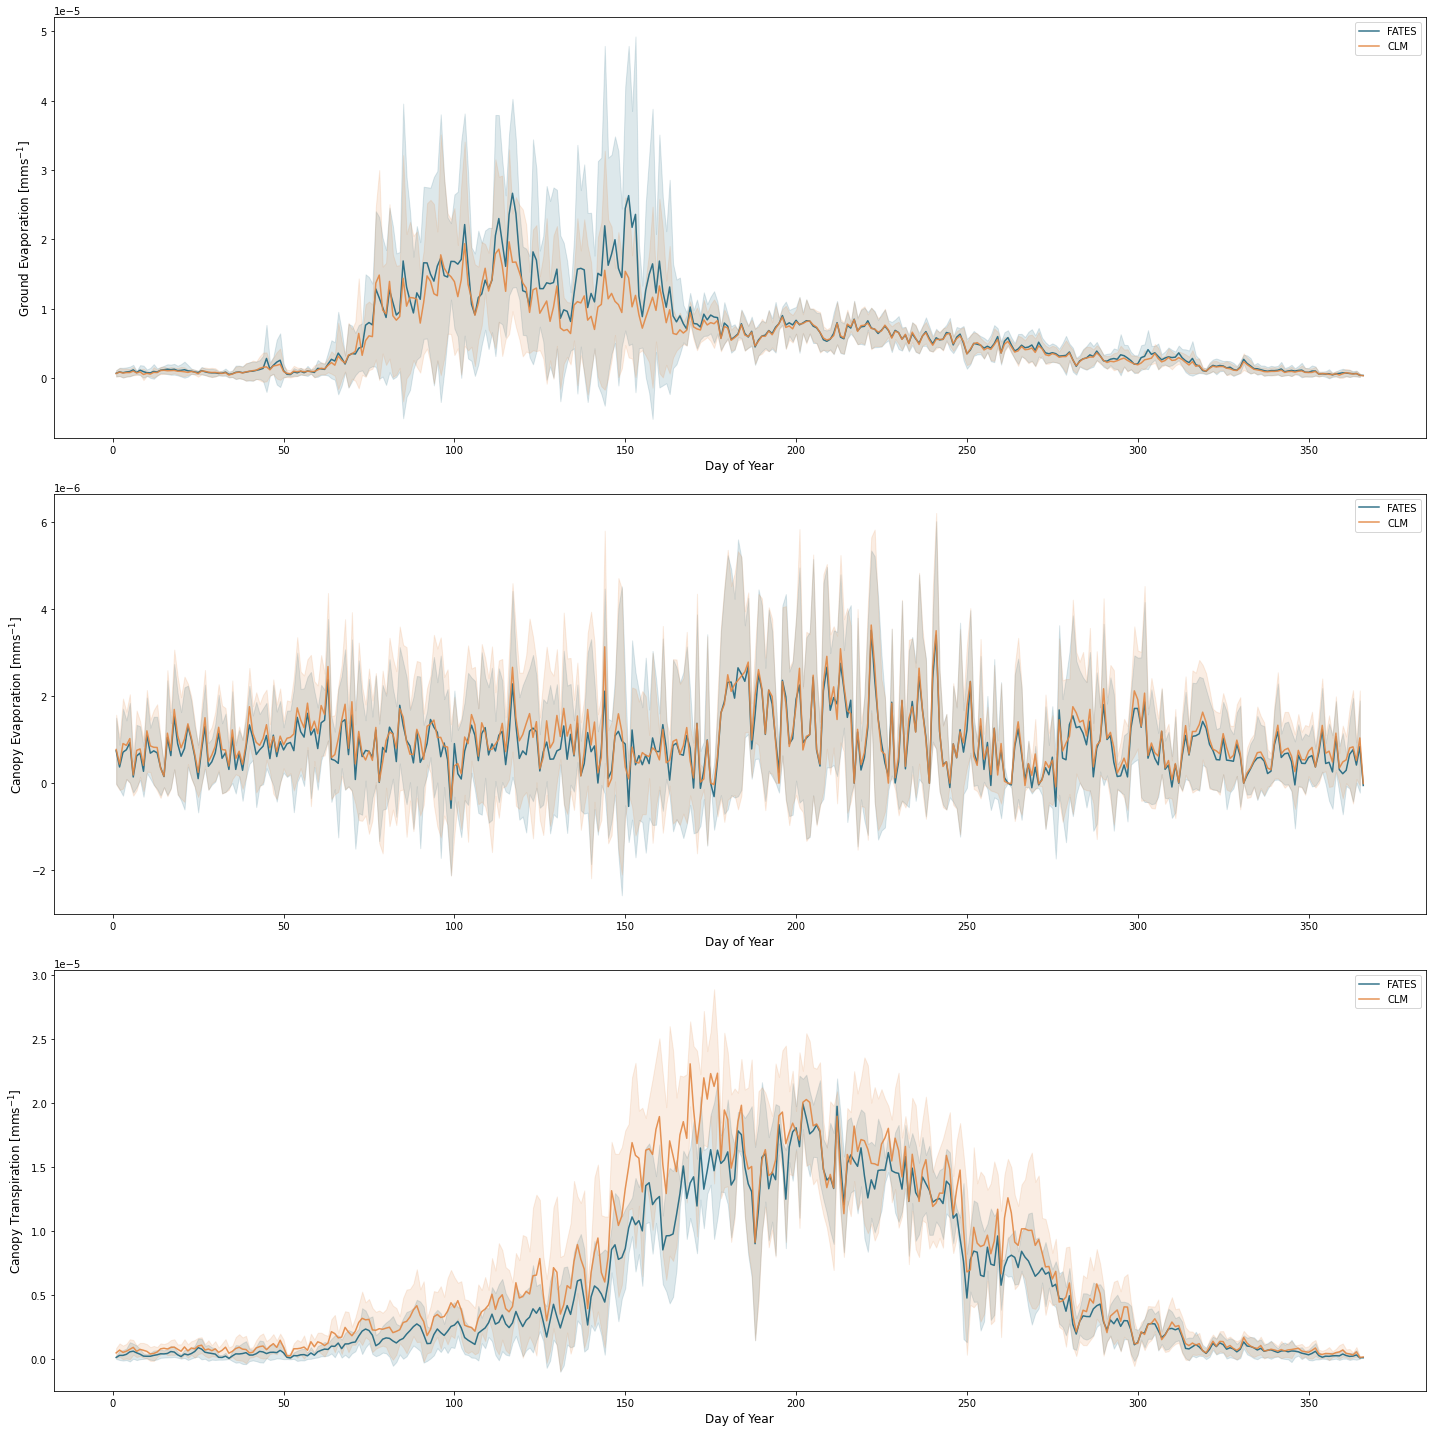

In [84]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(3, 1, 1)
plot_var_desc = "Ground Evaporation"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QSOIL'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_QSOIL'], color = color1,label="CLM", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QSOIL']-climo1SD['fates_sim_QSOIL'], climo1['fates_sim_QSOIL']+climo1SD['fates_sim_QSOIL'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_QSOIL']-climo1SD['sim_QSOIL'], climo1['sim_QSOIL']+climo1SD['sim_QSOIL'] ,alpha=0.15, color = color1)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 2)
plot_var_desc = "Canopy Evaporation"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QVEGE'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_QVEGE'], color = color1,label="CLM", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QVEGE']-climo1SD['fates_sim_QVEGE'], climo1['fates_sim_QVEGE']+climo1SD['fates_sim_QVEGE'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_QVEGE']-climo1SD['sim_QVEGE'], climo1['sim_QVEGE']+climo1SD['sim_QVEGE'] ,alpha=0.15, color = color1)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 3)
plot_var_desc = "Canopy Transpiration"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QVEGT'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_QVEGT'], color = color1,label="CLM", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QVEGT']-climo1SD['fates_sim_QVEGT'], climo1['fates_sim_QVEGT']+climo1SD['fates_sim_QVEGT'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_QVEGT']-climo1SD['sim_QVEGT'], climo1['sim_QVEGT']+climo1SD['sim_QVEGT'] ,alpha=0.15, color = color1)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates4.png')
plt.show()

## Original

In [64]:
# put my own code here to read in (split into blocks)

# -- merge two pandas dataframe on time
df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')

'''
# merges sim and obs dataframes on time (pandas datetime same?, possibly convert)

df_all=df_ctsm

clm_var = 'sim_EFLX_LH_TOT'
# -- Latent Heat Flux:
# -- EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

clm_var = 'sim_Rnet'
# -- Net Radiation:
# -- Rnet = FSA-FIRA
df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

clm_var = 'sim_NEE'
# -- Net Ecosystem Exchange
# -- NEE = GPP- (AR+HR)
# -- It seems like the sign are opposite so we calculated negative NEE
df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

'''
# convert NEE units from  umolm-2s-1 to gc/m2/s
#df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
#df_all ['GPP']= df_all ['GPP']*(12.01/1000000)

# -- convert gc/m2/s to gc/m2/day
df_all ['NEE']= df_all['NEE']*60*60*24
df_all ['GPP']= df_all['GPP']*60*60*24
'''
df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24
df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24
df_all ['sim_AR']= df_all['sim_AR']*60*60*24
df_all ['sim_HR']= df_all['sim_HR']*60*60*24
df_all ['sim_ER']= df_all['sim_HR']+df_all['sim_AR']

#-- extract year, month, day, hour information from time
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour

#tzone_shift = ds_eval.TimeDiffUtcLt
# hard coded for Mountain time
tzone_shift = -7

#convert to local time
df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
df_all['local_hour'] = df_all['local_time'].dt.hour
df_all['site']=neon_site

# Write out 30 minute data
#csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
#df_all.to_csv(csv_out,index=False)

#calculate daily means
df_all['local_date'] = df_all['local_time'].astype('M8[D]')
df_day = df_all.groupby(df_all['local_date']).mean()
#mask out days with missing values
df_count = df_all.groupby(df_all['local_date']).count()
df_day = df_day.where(df_count==48)

# Write out daily minute data
csv_out = join(csv_dir, "mean_daily_"+neon_site+".csv")
df_day.to_csv(csv_out,index=True)


end_site = time.time()
print ("Extracting data for "+neon_site+" took : ", end_site-start_site, "s.")
print ("Preprocessed file is saved as : ", csv_out)

except Exception as e: 
print (e)
print ('THIS SITE FAILED:', neon_site)
failed_sites.append(neon_site)
pass

SyntaxError: invalid syntax (2168988083.py, line 101)

In [8]:
ds_ctsm.H2OSOI


<xarray.DataArray 'H2OSOI' (time: 105120, lndgrid: 1)>
array([[0.3371491 ],
       [0.33714914],
       [0.33714914],
       ...,
       [0.2967561 ],
       [0.2967561 ],
       [0.2967561 ]], dtype=float32)
Coordinates:
  * time     (time) object '2016-01-01 00:00:00' ... '2021-12-29 23:30:00'
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      volumetric soil water (natural vegetated and crop landuni...
    units:          mm3/mm3
    cell_methods:   time: mean
    landunit_mask:  veg

In [4]:
df1 = pd.read_csv('/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_hist.csv')
df2 = pd.read_csv('/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_aspen_hist.csv')

In [5]:
df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df2['time'] = pd.to_datetime(df2['local_date'],format= '%Y-%m-%d' )
df2['time2'] = pd.to_datetime(df2['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df2['DOY'] = df2['time'].dt.dayofyear
df1 = df1.set_index('time')
df2 = df2.set_index('time')

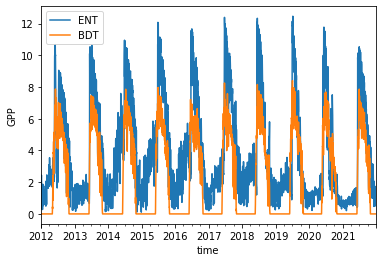

In [6]:
df1.sim_GPP.plot(label='ENT') ;
df2.sim_GPP.plot(label='BDT') ;
plt.ylabel('GPP');
plt.legend() ;

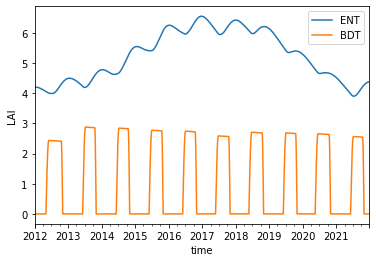

In [7]:
df1.sim_ELAI.plot(label='ENT') ;
df2.sim_ELAI.plot(label='BDT') ;
plt.ylabel('LAI');
plt.legend()


In [13]:
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo2 = df2.groupby(df2.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()
climo2SD = df2.groupby(df2.time2.dt.dayofyear).std()
climo1.var()

sim_QVEGT          7.612738e-11
sim_QVEGE          5.040761e-12
sim_QSOIL          1.428320e-13
sim_RAIN           1.694962e-10
sim_SNOW           5.623734e-10
sim_Vcmx25Z        5.448288e+01
sim_AR             7.954230e-01
sim_ESAI           0.000000e+00
sim_HTOP           1.361325e-04
sim_ELAI           2.593255e-02
sim_FCEV           3.152996e+01
sim_FCTR           4.761768e+02
sim_FGEV           8.955892e-01
sim_FIRA           1.864355e+02
sim_FSA            3.328667e+03
sim_FSR            6.081036e+01
sim_FSDS           4.265845e+03
sim_FSH            1.293019e+03
sim_GPP            7.253402e+00
sim_H2OSOI         9.240332e-04
sim_HR             3.820276e+00
sim_SNOW_DEPTH     1.622973e-01
sim_TBOT           5.915313e+01
sim_TSOI           2.614165e+01
sim_BTRANMN                 NaN
sim_TV             5.216743e+01
sim_AGNPP          2.889708e-11
sim_EFLX_LH_TOT    4.414214e+02
sim_Rnet           2.979532e+03
sim_NEE            2.877460e-01
sim_ER             7.898760e+00
year    

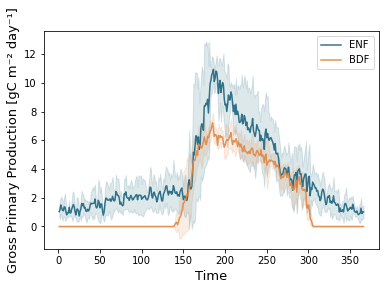

In [14]:
var = 'sim_GPP'
color1= '#e28743'
color2='#1d657e'

plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"
#plot_var = var.obs_var
#sim_var = var.sim_var
#plot_var_desc = var.long_name
#lot_var_unit = var.unit
    
plt.plot ( climo1.DOY, climo1[var], color = color2, label="ENF", alpha = 0.9)
plt.plot ( climo2.DOY, climo2[var], color = color1,label="BDF", alpha = 0.9)
    
plt.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
plt.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

plt.xlabel('Time', fontsize=13)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
plt.legend();
#    ax.margins(x=0.02)


In [15]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name

In [16]:
all_vars= [] 

plot_var = 'SNOW_DEPTH'
sim_var = 'sim_'+plot_var
plot_var_desc = "Snow Depth"
plot_var_unit= "m"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'TSOI'
sim_var = plot_var
plot_var_desc = "Soil Temperature"
plot_var_unit= "deg C"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'H2OSOI'
sim_var = 'sim_'+plot_var
plot_var_desc = "Soil Moisture"
plot_var_unit= "$\mathrm{mm^{3}  mm^{-3}}$"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'GPP'
sim_var = 'sim_'+plot_var
plot_var_desc = "GPP"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'HR'
sim_var = 'sim_'+plot_var
plot_var_desc = "HR"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)


$\mathrm{mm^{3}  mm^{-3}}$

In [22]:
def shaded_tseries(climo1, climo1SD, climo2, climo2SD, var, ax, ln, unit, color1= '#e28743',color2='#1d657e' ):
    
    var = var.sim_var
    plot_var_desc = ln
    plot_var_unit = unit
    
    ax.plot ( climo1.DOY, climo1[var], color = color2, label="Spruce", alpha = 0.9)
    ax.plot ( climo2.DOY, climo2[var], color = color1,label="Aspen", alpha = 0.9)
    
    ax.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
    ax.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

    ax.set_xlabel('Time', fontsize=13)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
    ax.margins(x=0.02)


In [23]:
var in enumerate(all_vars)

False

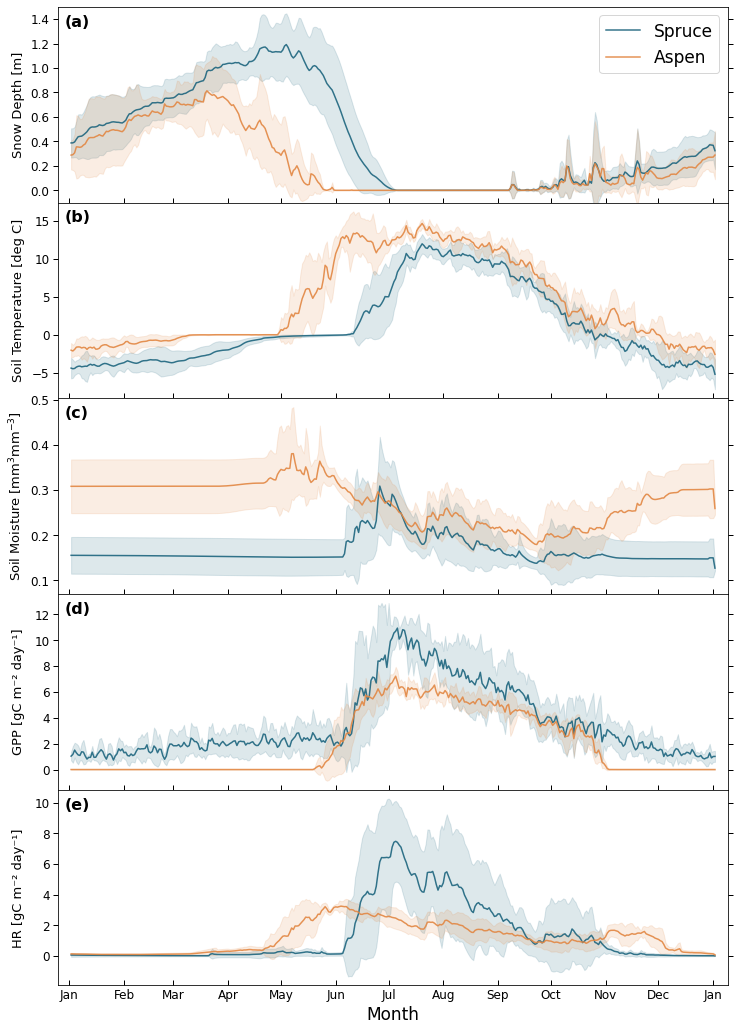

In [24]:
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
import matplotlib.dates as mdates

fig = plt.figure(num=None, figsize=(12, 18),  facecolor='w', edgecolor='k')
axes = fig.subplots(nrows=5, ncols=1)
axe = axes.ravel()
for index, var in enumerate(all_vars):
    ax = axe[index]    
    ln = var.long_name
    unit = var.unit
    
    shaded_tseries ( climo1, climo1SD, climo2, climo2SD, var, ax, ln, unit)

    ax.text(.01,0.90,panel_labels[index],
        horizontalalignment='left',
        transform=ax.transAxes, fontweight='bold',fontsize=16)

    # Set the locator for boxplots
    locator = mdates.MonthLocator()  # every month

    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%b')            

    # add a title
    if index == 0:
    #    ax.text(.5,1.03,'NEON site : '+neon_site + ' [2018-2021]',
    #    horizontalalignment='center',
    #    transform=ax.transAxes, fontweight='bold',fontsize=19)
        ax.legend(fontsize = 17)
        ax.set_ylim([-0.1,1.5])

    ax.tick_params(axis='both', which='both', labelsize=12,width=1,length=5)
    ax.tick_params(axis='x',direction="in", length = 5)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y',direction="out", length = 5)

    X=ax.xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)

    ax.get_yaxis().set_label_coords(-0.05,0.5)

    if index == 5:
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        X.set_major_formatter(fmt)

ax.set_xlabel('Month', fontsize=17)
fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

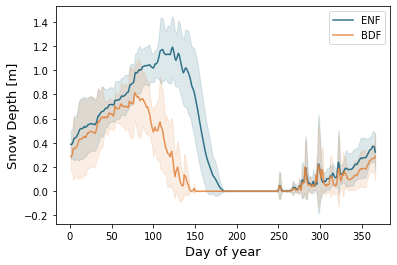

In [20]:
var = 'sim_SNOW_DEPTH'
color1= '#e28743'
color2='#1d657e'

plot_var_desc = "Snow Depth"
plot_var_unit= "m"
    
plt.plot ( climo1.DOY, climo1[var], color = color2, label="ENF", alpha = 0.9)
plt.plot ( climo2.DOY, climo2[var], color = color1,label="BDF", alpha = 0.9)
    
plt.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
plt.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

plt.xlabel('Day of year', fontsize=13)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
plt.legend();
#    ax.margins(x=0.02)


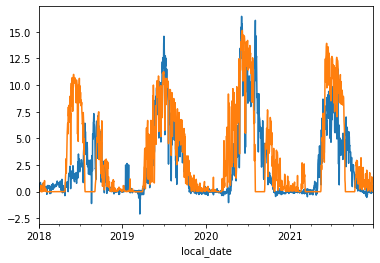

In [28]:
df_day.GPP.plot();
df_day.sim_GPP.plot();

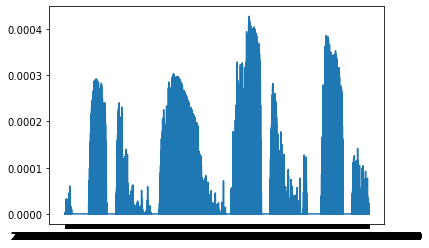

In [30]:
#ds_ctsm.FSDSNDLN.isel(lndgrid=0).plot() ;
plt.plot(ds_ctsm.time, ds_ctsm.GPP.isel(lndgrid=0)) ;